## Predicciones en el Mercado Inmobiliario de Dinamarca

#### 1. Análisis exploratorio de los datos analizando las diferentes regiones, precios, tamaños, características, tipos... a lo largo de los años.

#### 2. Predicciones sobre las futuras ventas de casas, precios según las regiones, tamaños y tipos de casa predominante.

## 1. EDA

In [10]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import matplotlib.patches as mpatches
import seaborn as sns
import folium
from folium.plugins import HeatMap
from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter

%matplotlib inline
plt.rcParams['figure.figsize'] = (16, 9)
plt.style.use('ggplot')

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LinearRegression
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

In [11]:
#Cargar csv
df_houses = pd.read_csv('houses.csv')
#Filtro para solo años por encima de 1800
df_houses_year = df_houses[df_houses['year_build'] > 1800]

### Limpieza de datos

In [12]:
#Eliminar columnas sin interés
columns_to_drop = ['yield_on_mortgage_credit_bonds%']
df_houses = df_houses.drop(columns=columns_to_drop)

In [13]:
# Contar el número de filas duplicadas
num_duplicates = df_houses.duplicated().sum()
print(f"Número de filas duplicadas: {num_duplicates}")

Número de filas duplicadas: 0


In [14]:
# Encontrar filas duplicadas
filas_duplicadas = df_houses[df_houses.duplicated()]

In [15]:
def valores_faltantes(data):
  total = data.isnull().sum()
  porcentaje = (data.isnull().sum()/data.isnull().count()*100)
  tt = pd.concat([total, porcentaje], axis=1, keys=['Total', 'Porcentaje'])
  types = []
  for col in data.columns:
    dtype = str(data[col].dtype)
    types.append(dtype)
  tt['Tipos'] = types
  return np.transpose(tt)

valores_faltantes(df_houses)

date quarter house_id house_type sales_type year_build  \
Total            0       0        0          0          0          0   
Porcentaje     0.0     0.0      0.0        0.0        0.0        0.0   
Tipos       object  object    int64     object     object      int64   

           purchase_price %_change_between_offer_and_purchase no_rooms  \
Total                   0                                   0        0   
Porcentaje            0.0                                 0.0      0.0   
Tipos               int64                             float64    int64   

                sqm sqm_price address zip_code    city    area  region  \
Total             0         0       0        0      11       0       0   
Porcentaje      0.0       0.0     0.0      0.0   0.011     0.0     0.0   
Tipos       float64   float64  object    int64  object  object  object   

           nom_interest_rate% dk_ann_infl_rate%  
Total                       0                77  
Porcentaje                0.0             0.077  
Tipos                 float64           float64

In [16]:
df_houses['city'].unique()

array(['Solrød Strand', 'Frederiksberg C', 'Kalundborg', 'Farum',
       'Svendborg', 'Skovlunde', 'Erslev', 'Branderup J', 'Holsted',
       'Esbjerg', 'Jægerspris', 'Silkeborg', 'Snertinge', 'Agedrup',
       'Hornbæk', 'Sønderborg', 'Aabenraa', 'Fredericia', 'Roskilde',
       'Alsted', 'Aarhus C', 'Odense C', 'Ikast', 'Aars', 'Barrit',
       'Faxe', 'Sjællands Odde', 'Hurup Thy', 'Valby', 'Humlebæk',
       'Slagelse', 'Vig', 'Charlottenlund', 'Greve', 'Odense N',
       'Store Fuglede', 'Ringsted', 'Idestrup', 'Skødstrup',
       'Nykøbing Sj', 'København N', 'Karby', 'Faaborg', 'Ã\x85lsgårde',
       'Lemvig', 'Ansager', 'Gjerlev J', 'Hørsholm', 'Assens',
       'Vordingborg', 'Aulum', 'Ebeltoft', 'Bogense', 'Løgstrup',
       'Glostrup', 'Skive', 'Fuglebjerg', 'Astbirk', 'Rødekro', 'Malling',
       'Randers NV', 'Ringkøbing', 'Herning', 'Arbæk', 'Brovst', 'Søborg',
       'Fanø', 'Gentofte', 'Hedehusene', 'Aalborg', 'Tarm', 'Sunds',
       'Helsinge', 'Mørkøv', 'Nexø', 'Højsle

### Observar datos

In [17]:
df_houses_year = df_houses[df_houses['year_build'] > 1800]
df_houses.head()

date quarter  house_id house_type    sales_type  year_build  \
0  2024-10-24  2024Q4        16      Villa  regular_sale        1997   
1  2024-10-24  2024Q4        13  Apartment  regular_sale        1885   
2  2024-10-23  2024Q4        60      Villa  regular_sale        1949   
3  2024-10-23  2024Q4        29      Villa  regular_sale        2001   
4  2024-10-22  2024Q4        92  Apartment  regular_sale        1965   

   purchase_price  %_change_between_offer_and_purchase  no_rooms    sqm  \
0         6500000                                 -3.0         5  142.0   
1         3400000                                  0.0         2   46.0   
2         4550000                                 -4.0         4  112.0   
3         1630000                                -12.0         4  186.0   
4         1975000                                -10.0         3   82.0   

   sqm_price                          address  zip_code             city  \
0  45774.650                     Spættevej 16      2680    Solrød Strand   
1  73913.050  Jakob Dannefærds Vej 10B, 4. th      1973  Frederiksberg C   
2  40625.000             Vestre Plantagevej 3      2680    Solrød Strand   
3   8763.440                     Toftebjerg 3      4400       Kalundborg   
4  24085.365        Ryttergårdsvej 20, 1. 113      3520            Farum   

                  area   region  nom_interest_rate%  dk_ann_infl_rate%  
0  Capital, Copenhagen  Zealand                 3.1                NaN  
1  Capital, Copenhagen  Zealand                 3.1                NaN  
2  Capital, Copenhagen  Zealand                 3.1                NaN  
3        Other islands  Zealand                 3.1                NaN  
4        North Zealand  Zealand                 3.1                NaN

In [18]:
print(df_houses.index)
print(df_houses.shape)
df_houses.info()

RangeIndex(start=0, stop=100000, step=1)
(100000, 18)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 18 columns):
 #   Column                               Non-Null Count   Dtype  
---  ------                               --------------   -----  
 0   date                                 100000 non-null  object 
 1   quarter                              100000 non-null  object 
 2   house_id                             100000 non-null  int64  
 3   house_type                           100000 non-null  object 
 4   sales_type                           100000 non-null  object 
 5   year_build                           100000 non-null  int64  
 6   purchase_price                       100000 non-null  int64  
 7   %_change_between_offer_and_purchase  100000 non-null  float64
 8   no_rooms                             100000 non-null  int64  
 9   sqm                                  100000 non-null  float64
 10  sqm_price                  

In [19]:
df_houses.describe()

house_id     year_build  purchase_price  \
count  1.000000e+05  100000.000000    1.000000e+05   
mean   7.531364e+05    1955.078530    1.925992e+06   
std    4.348902e+05      45.703585    1.777832e+06   
min    1.300000e+01    1000.000000    2.502000e+05   
25%    3.770722e+05    1931.000000    8.000000e+05   
50%    7.511035e+05    1966.000000    1.400000e+06   
75%    1.128904e+06    1980.000000    2.450000e+06   
max    1.507901e+06    2024.000000    4.595500e+07   

       %_change_between_offer_and_purchase       no_rooms            sqm  \
count                        100000.000000  100000.000000  100000.000000   
mean                             -2.084740       4.375790     129.387820   
std                               4.852926       1.661686      57.170619   
min                             -49.000000       1.000000      26.000000   
25%                              -3.000000       3.000000      89.000000   
50%                               0.000000       4.000000     123.000000   
75%                               0.000000       5.000000     160.000000   
max                              49.000000      15.000000     984.000000   

           sqm_price       zip_code  nom_interest_rate%  dk_ann_infl_rate%  
count  100000.000000  100000.000000       100000.000000       99923.000000  
mean    16406.648074    5951.612680            1.679263           1.927025  
std     13655.184405    2369.938171            2.048078           1.638440  
min       374.549800    1051.000000            0.000000           0.250000  
25%      6792.940775    4000.000000            0.000000           0.790000  
50%     12070.707000    5970.000000            0.750000           1.850000  
75%     21343.201500    8250.000000            3.250000           2.340000  
max     75000.000000    9990.000000            9.500000           7.700000

In [20]:
df_houses.describe(include='object')

date quarter house_type    sales_type    address         city  \
count       100000  100000     100000        100000     100000        99989   
unique       11254     130          5             4      92463          607   
top     2023-12-19  2021Q1      Villa  regular_sale  Vibevej 2  København S   
freq            49    2263      54214         88232         12         1275   

                 area   region  
count          100000   100000  
unique              8        4  
top     South jutland  Jutland  
freq            22563    49937

### Análisis Univariante

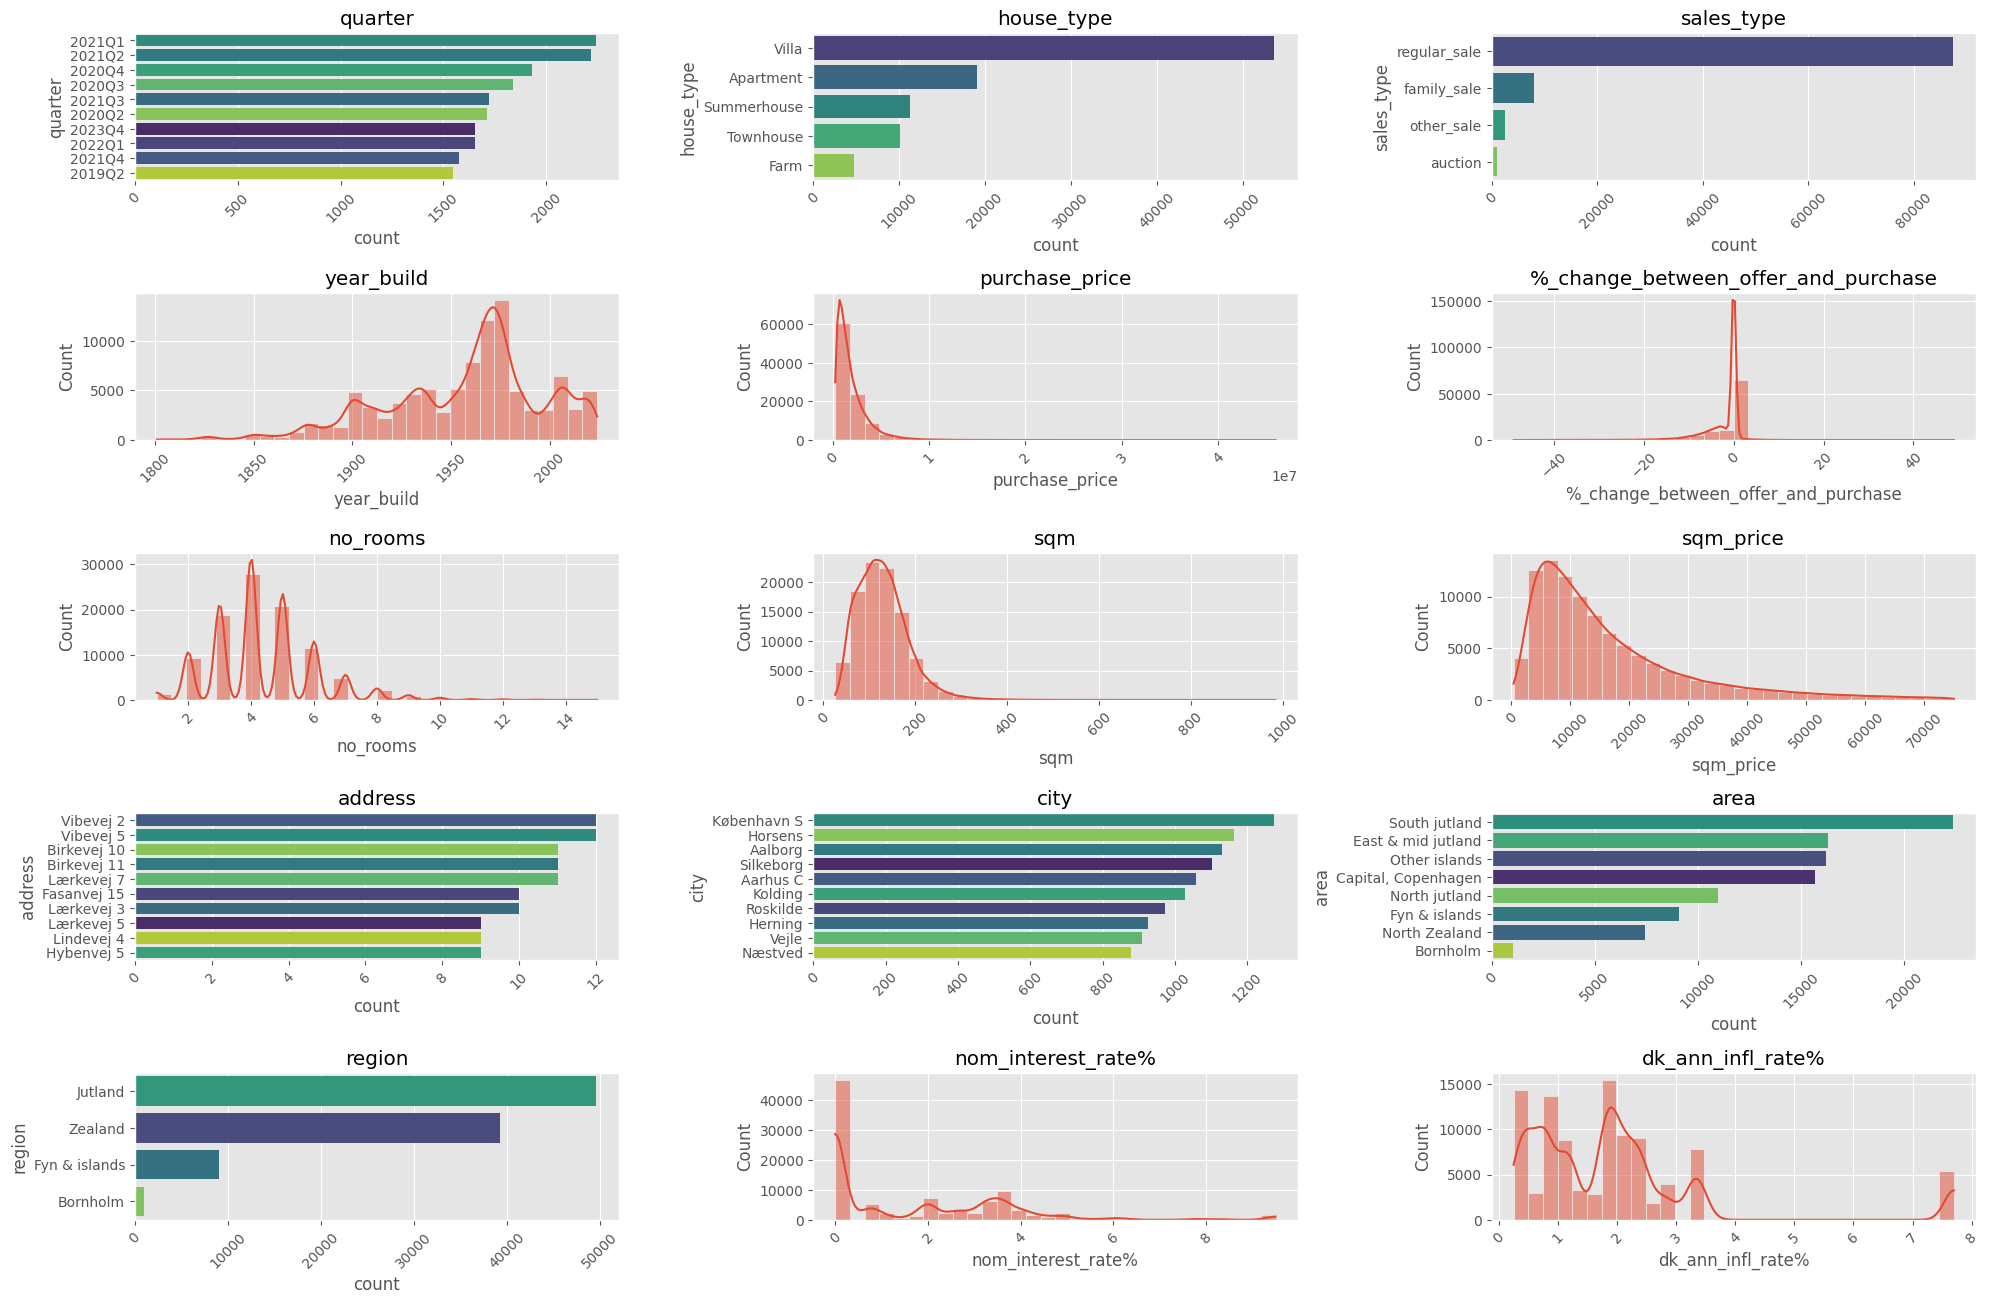

In [21]:
import math

# Análisis univariante
def analisis_univariante(data, cols=3, width=20, height=15):
    # Crear una figura con el tamaño definido por los parámetros width y height
    fig = plt.figure(figsize=(width, height))

    # Calcular el número de filas necesarias para acomodar todas las columnas en la gráfica
    rows = math.ceil(data.shape[1] / cols)

    # Contador para los subplots
    plot_index = 1

    # Iterar sobre cada columna en el dataset
    for column in data.columns:
        if column in ['house_id', 'date','zip_code']:
            continue  # Omitir las columnas especificadas

        # Crear subplots, añadiendo cada uno en su posición dentro de la cuadrícula de filas y columnas
        ax = fig.add_subplot(rows, cols, plot_index)
        plot_index += 1

        # Establecer el título de cada subplot como el nombre de la columna actual
        ax.set_title(column)

        if data[column].dtype == 'object':
            # Limitar el número de categorías a mostrar
            top_categories = data[column].value_counts().index[:10]
            sns.countplot(data=data[data[column].isin(top_categories)], y=column, ax=ax, palette='viridis', order=top_categories, hue=column, legend=False)
            plt.xticks(rotation=45)
        else:
            # Usar un histograma con KDE para columnas numéricas, limitando el número de bins
            sns.histplot(data[column], ax=ax, kde=True, bins=30)
            plt.xticks(rotation=45)

    # Ajustar el layout de la figura para evitar solapamientos entre subplots
    plt.tight_layout()
    plt.show()

analisis_univariante(df_houses_year)

### Sesgo

In [22]:
# Calcular la asimetría y la curtosis de las variables numéricas
sesgo = df_houses.select_dtypes(include=['float64', 'int64']).skew()
curtosis = df_houses.select_dtypes(include=['float64', 'int64']).kurt()

# Crear un dataframe con los resultados
sesgo_curtosis = pd.DataFrame({'Sesgo': sesgo, 'Curtosis': curtosis})

print(sesgo_curtosis)

                                        Sesgo   Curtosis
house_id                             0.004244  -1.197434
year_build                          -2.449721  28.856312
purchase_price                       3.434825  25.456699
%_change_between_offer_and_purchase -2.628064  18.915827
no_rooms                             0.913627   2.271718
sqm                                  1.696632  10.454610
sqm_price                            1.674143   2.841695
zip_code                            -0.013770  -1.268616
nom_interest_rate%                   1.350773   2.179242
dk_ann_infl_rate%                    2.243389   5.604241


### Comparar precios a lo largo del tiempo según tipo de casa

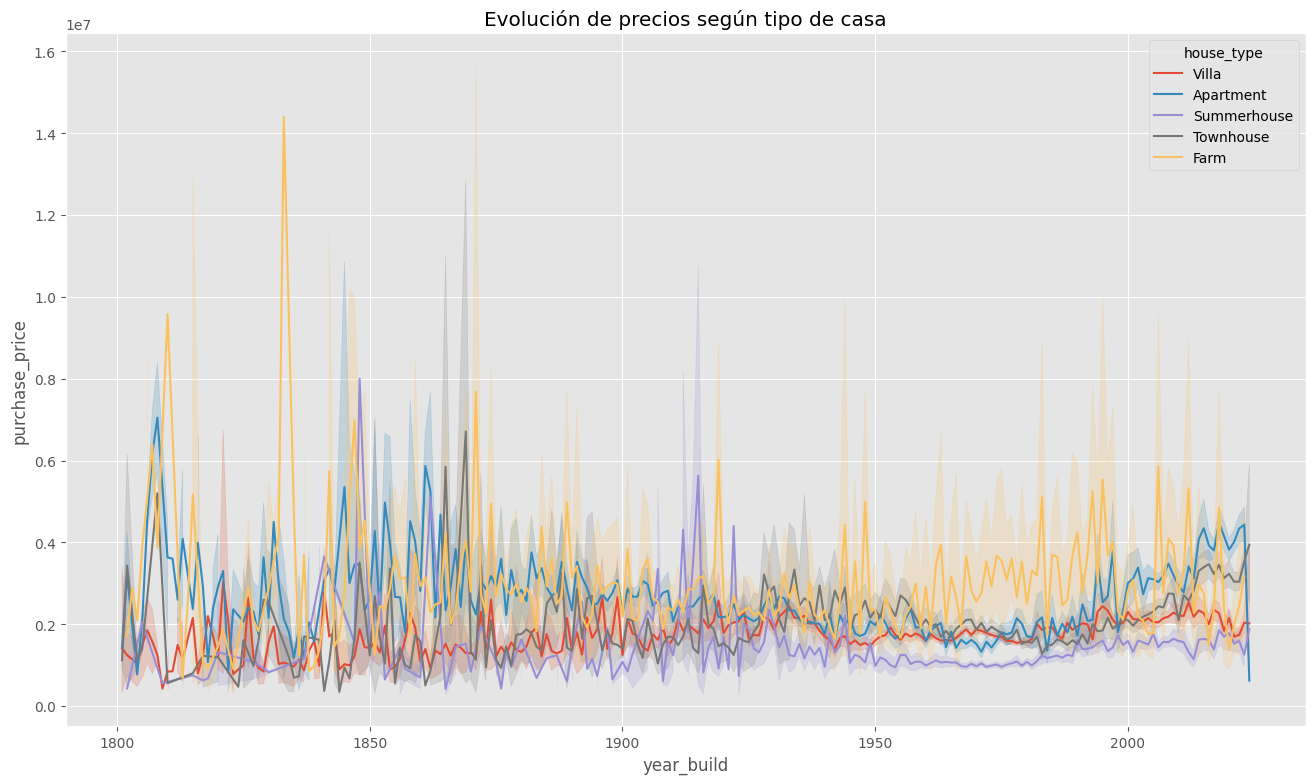

In [23]:
#Gráfico de evolución de precios según house_type
sns.lineplot(x='year_build', y='purchase_price', data=df_houses_year, hue='house_type')
plt.title('Evolución de precios según tipo de casa')
plt.show()

### Comparar los precios según región a lo largo del tiempo

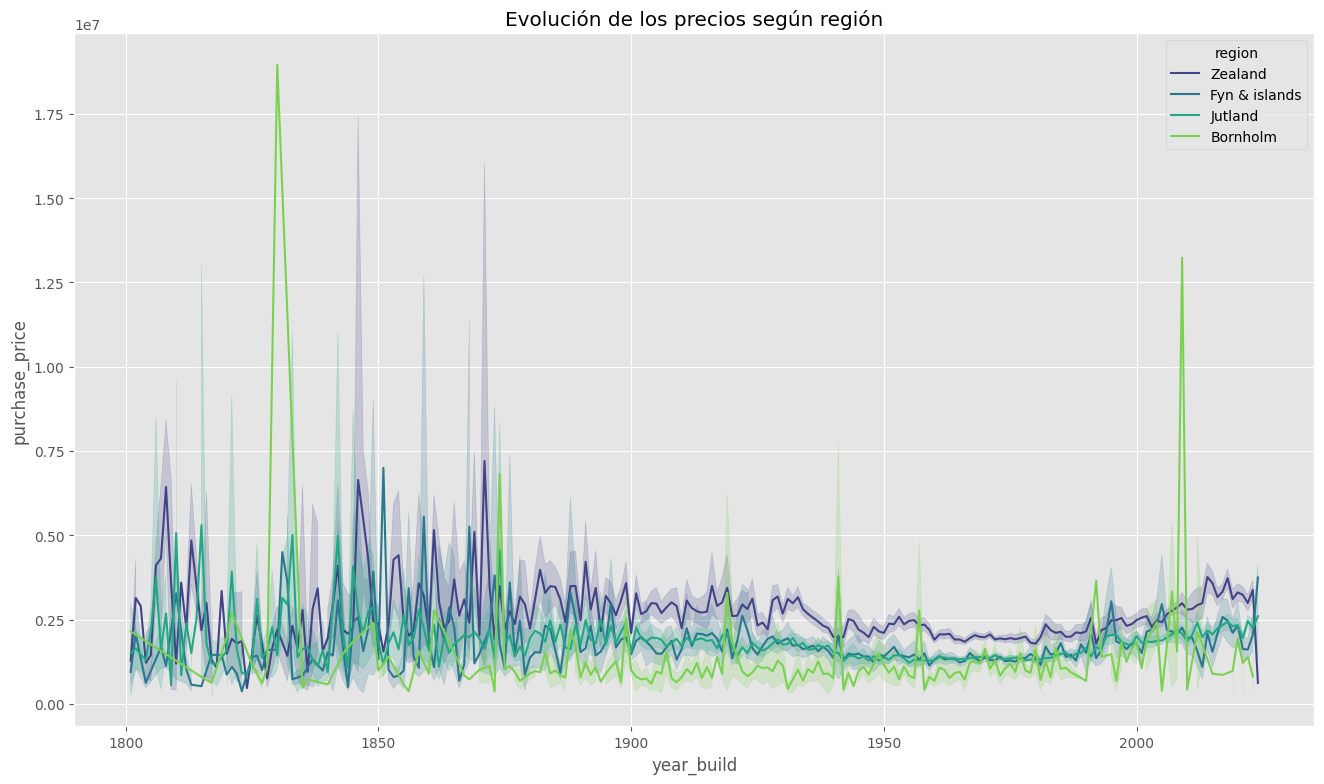

In [24]:
# Gráfico de la evolución de los precios según region
plt.figure(figsize=(16, 9))
sns.lineplot(x='year_build', y='purchase_price', data=df_houses_year, hue='region', palette='viridis')
plt.title('Evolución de los precios según región')
plt.show()

### Comparar tamaño y precio según región

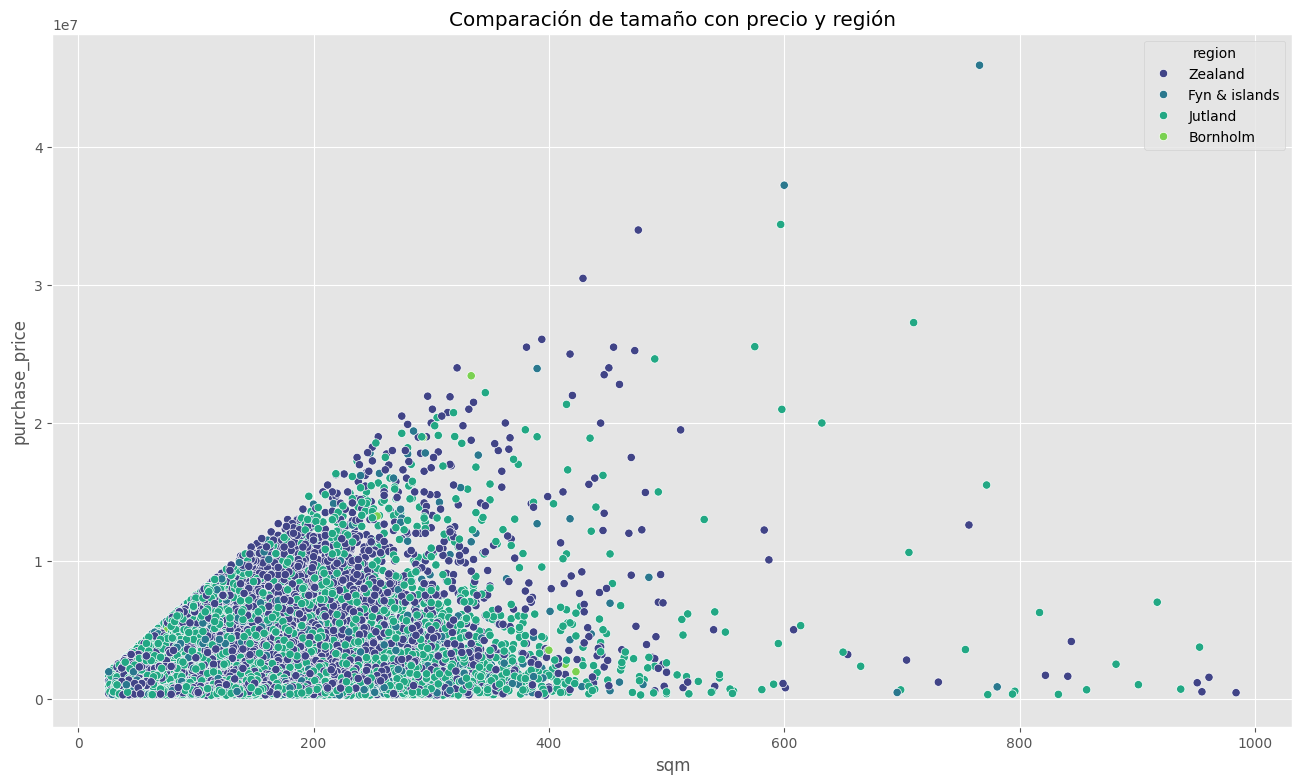

In [25]:
# Gráfico para comparar sqm con purchase_price y region
plt.figure(figsize=(16, 9))
sns.scatterplot(x='sqm', y='purchase_price', data=df_houses, hue='region', palette='viridis')
plt.title('Comparación de tamaño con precio y región')
plt.show()

### Comparar Precio y tamaño a lo largo de los años

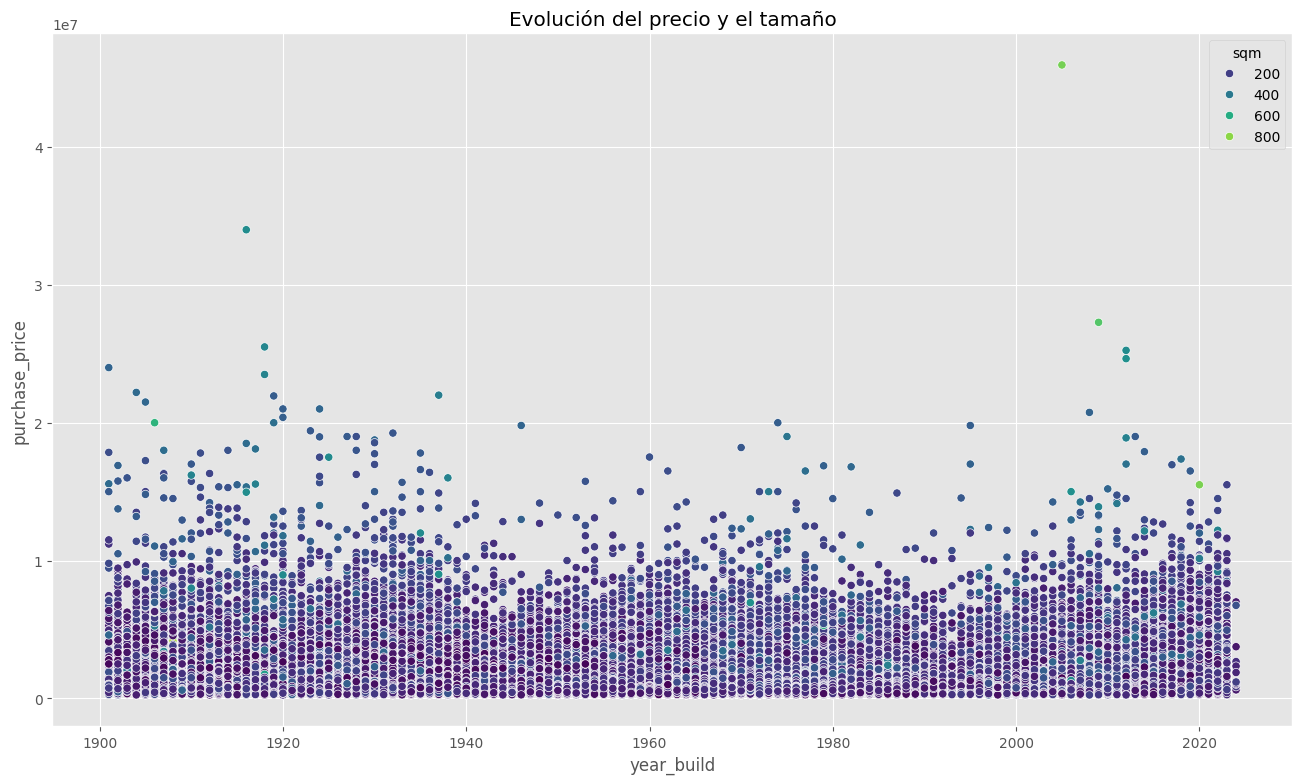

In [26]:
#Filtro para solo años por encima de 1900
df_houses_1900 = df_houses[df_houses['year_build'] > 1900]
#Gráfico para comparar year_build con purchase_price y sqm
plt.figure(figsize=(16, 9))
sns.scatterplot(x='year_build', y='purchase_price', data=df_houses_1900, hue='sqm', palette='viridis')
plt.title('Evolución del precio y el tamaño')
plt.show()

### Evolución de tipos de casa en cada región

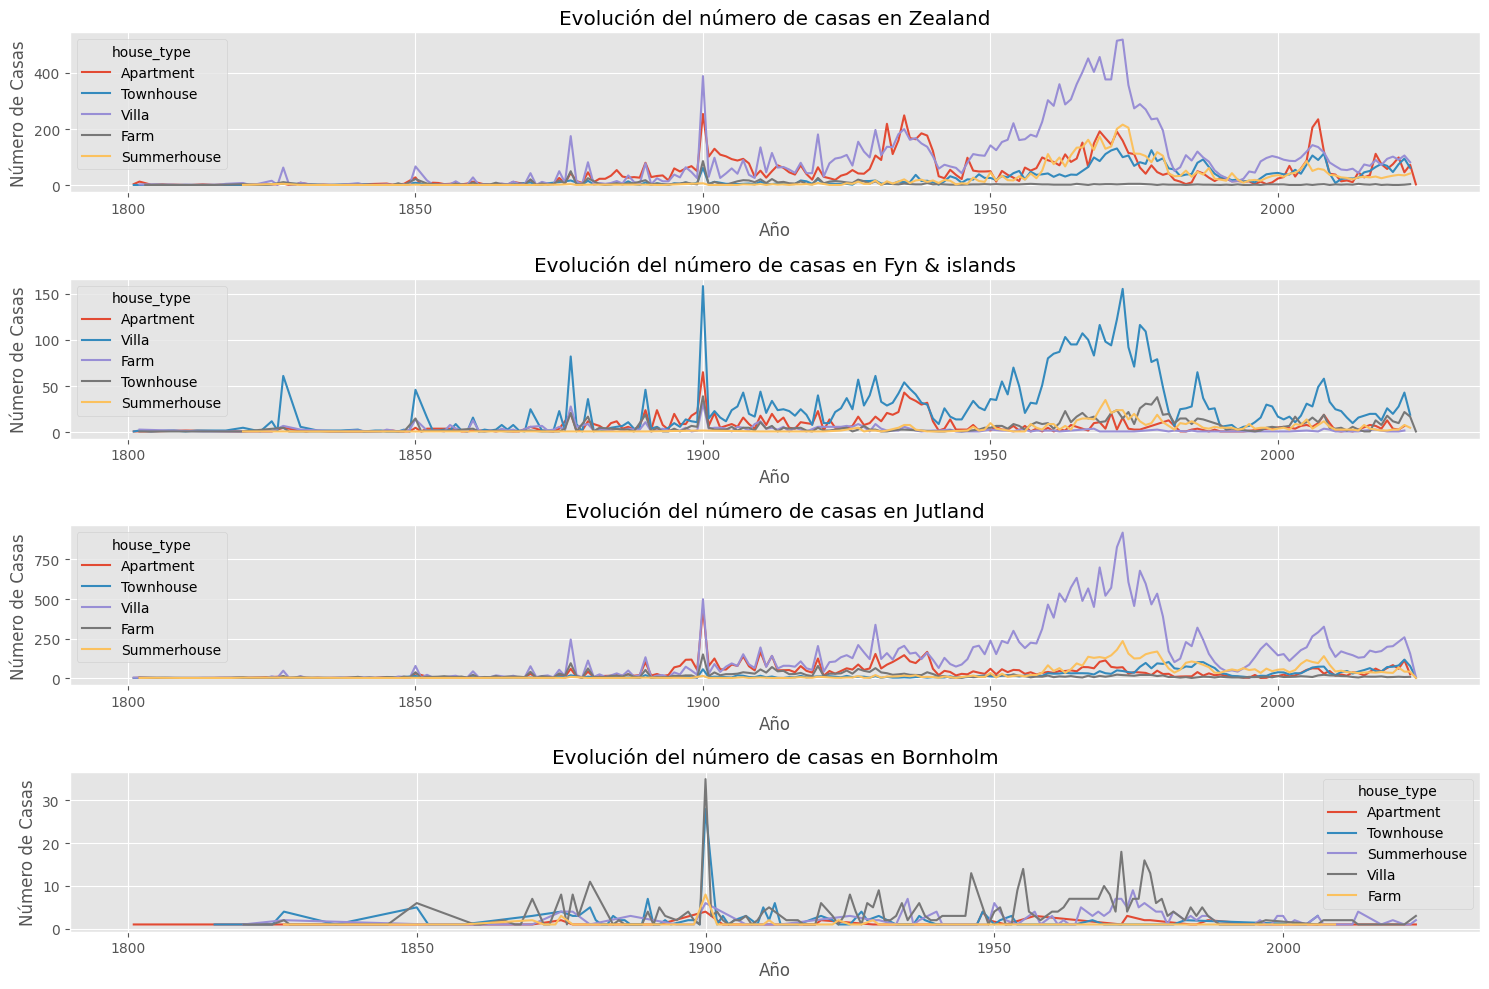

In [27]:
# funcion para contar
def contar(data, column1, column2):
  df = data.groupby(['year_build', column1, column2]).size().reset_index(name='counts')
  return df

# Crear el gráfico
plt.figure(figsize=(15, 10))

# Obtener las regiones únicas
regiones = df_houses_year['region'].unique()

# Crear un gráfico para cada región
for i, region in enumerate(regiones):
    df = contar(df_houses_year, 'region', 'house_type')
    plt.subplot(len(regiones), 1, i + 1)
    region_data = df[df['region'] == region]
    sns.lineplot(data=region_data, x='year_build', y='counts', hue='house_type')
    plt.title(f'Evolución del número de casas en {region}')
    plt.xlabel('Año')
    plt.ylabel('Número de Casas')

plt.tight_layout()
plt.show()

### Evolución de casas según región

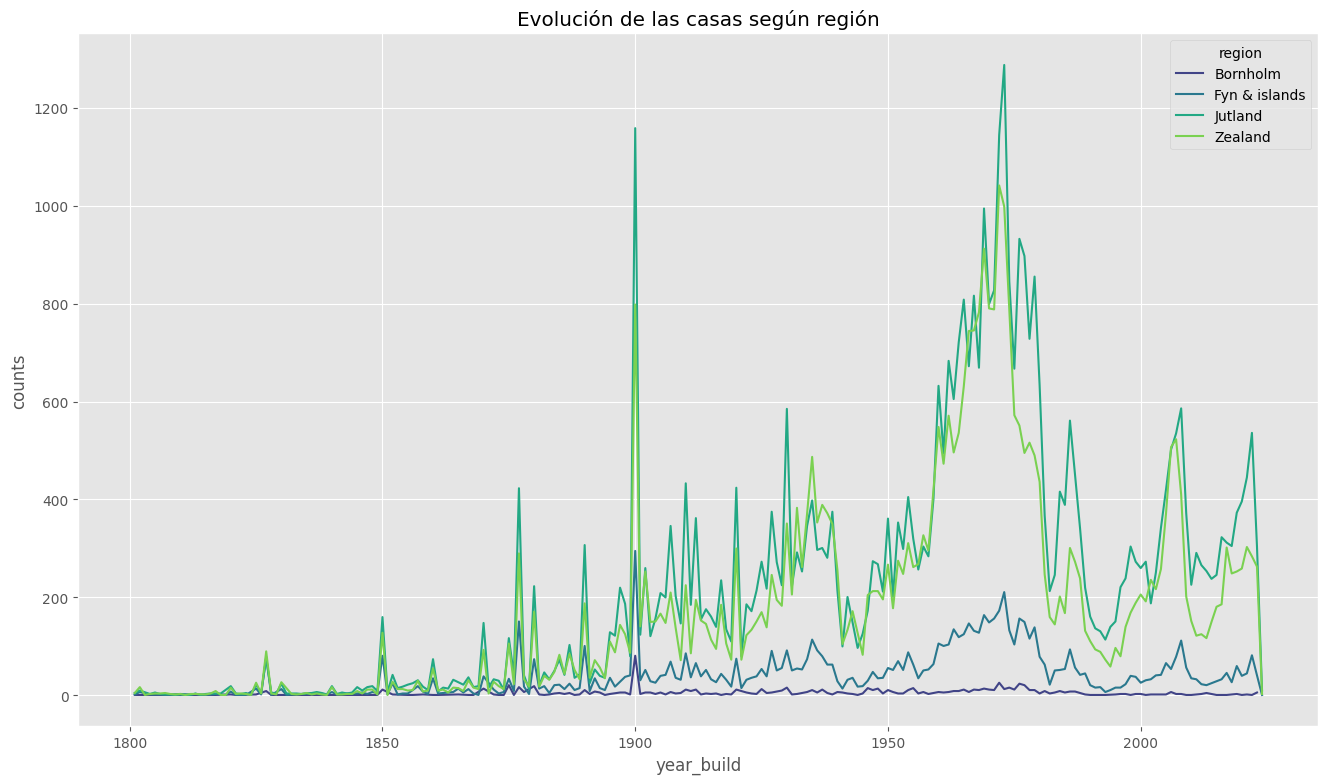

In [28]:
# funcion para contar solo una columna
def contar_una(data, column1):
  df = data.groupby(['year_build', column1]).size().reset_index(name='counts')
  return df

# Gráfico Evolución de número de casas según región a lo largo de los años
df = contar_una(df_houses_year, 'region')
plt.figure(figsize=(16, 9))
sns.lineplot(x='year_build', y='counts', data=df, hue='region', palette='viridis')
plt.title('Evolución de las casas según región')
plt.show()

### Evolución del número de habitaciones según región

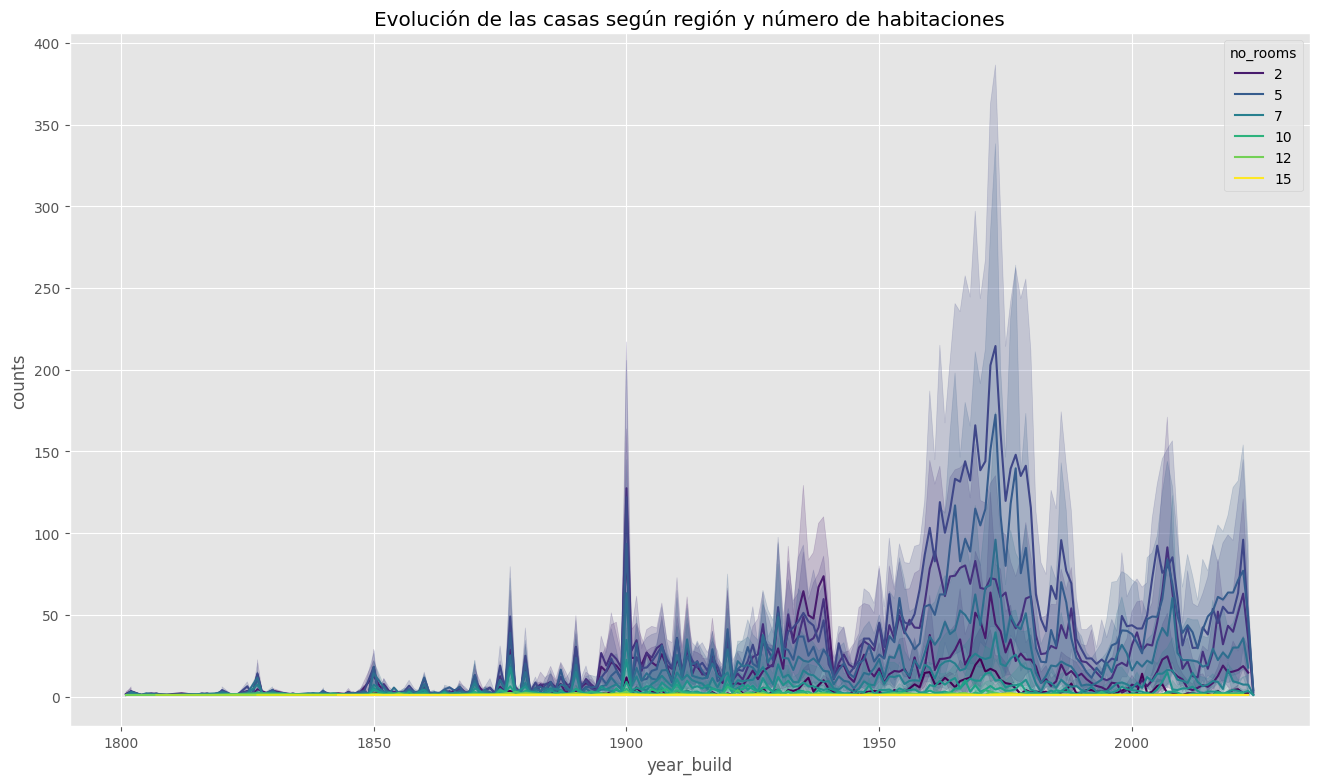

In [29]:
# gráfico Evolución del número de casas con diferente numero de habitaciones según región a lo largo de los años
df = contar(df_houses_year, 'region', 'no_rooms')
plt.figure(figsize=(16, 9))
sns.lineplot(x='year_build', y='counts', data=df, hue='no_rooms', palette='viridis')
plt.title('Evolución de las casas según región y número de habitaciones')
plt.show()

### Ventas

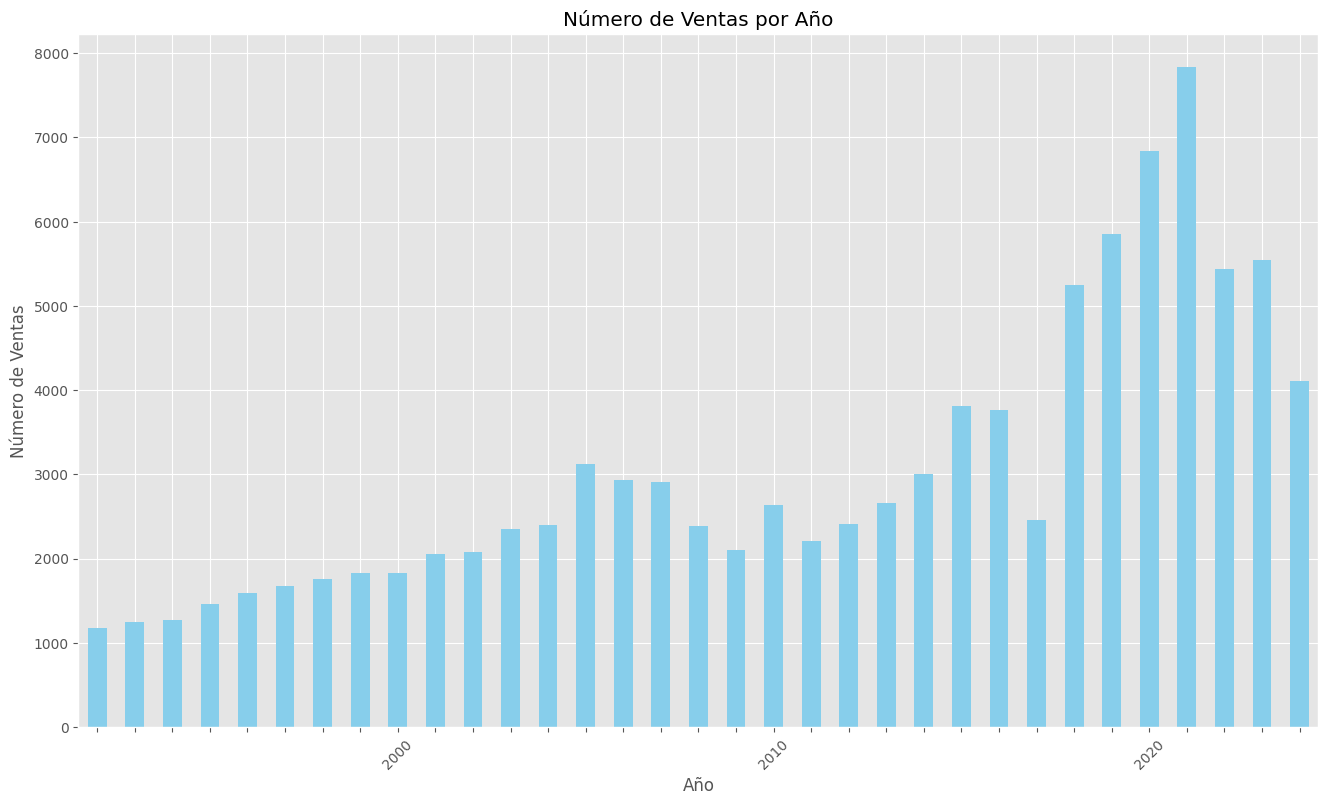

In [32]:
# Extraer el año de la columna 'date'
df_houses['year'] = pd.to_datetime(df_houses['date']).dt.year

# Contar el número de ventas por año
ventas_por_año = df_houses['year'].value_counts().sort_index()

# Graficar el número de ventas por año
plt.figure(figsize=(16, 9))
ax = ventas_por_año.plot(kind='bar', color='skyblue')
plt.title('Número de Ventas por Año')
plt.xlabel('Año')
plt.ylabel('Número de Ventas')

# Configurar los labels para que solo se muestren los años que terminan en 0
ticks = ventas_por_año.index
tick_labels = [str(year) if year % 10 == 0 else '' for year in ticks]
ax.set_xticklabels(tick_labels, rotation=45)

plt.show()

## 2. Predicciones Sobre Futuras Construcciones

### Precios por región en los próximos años

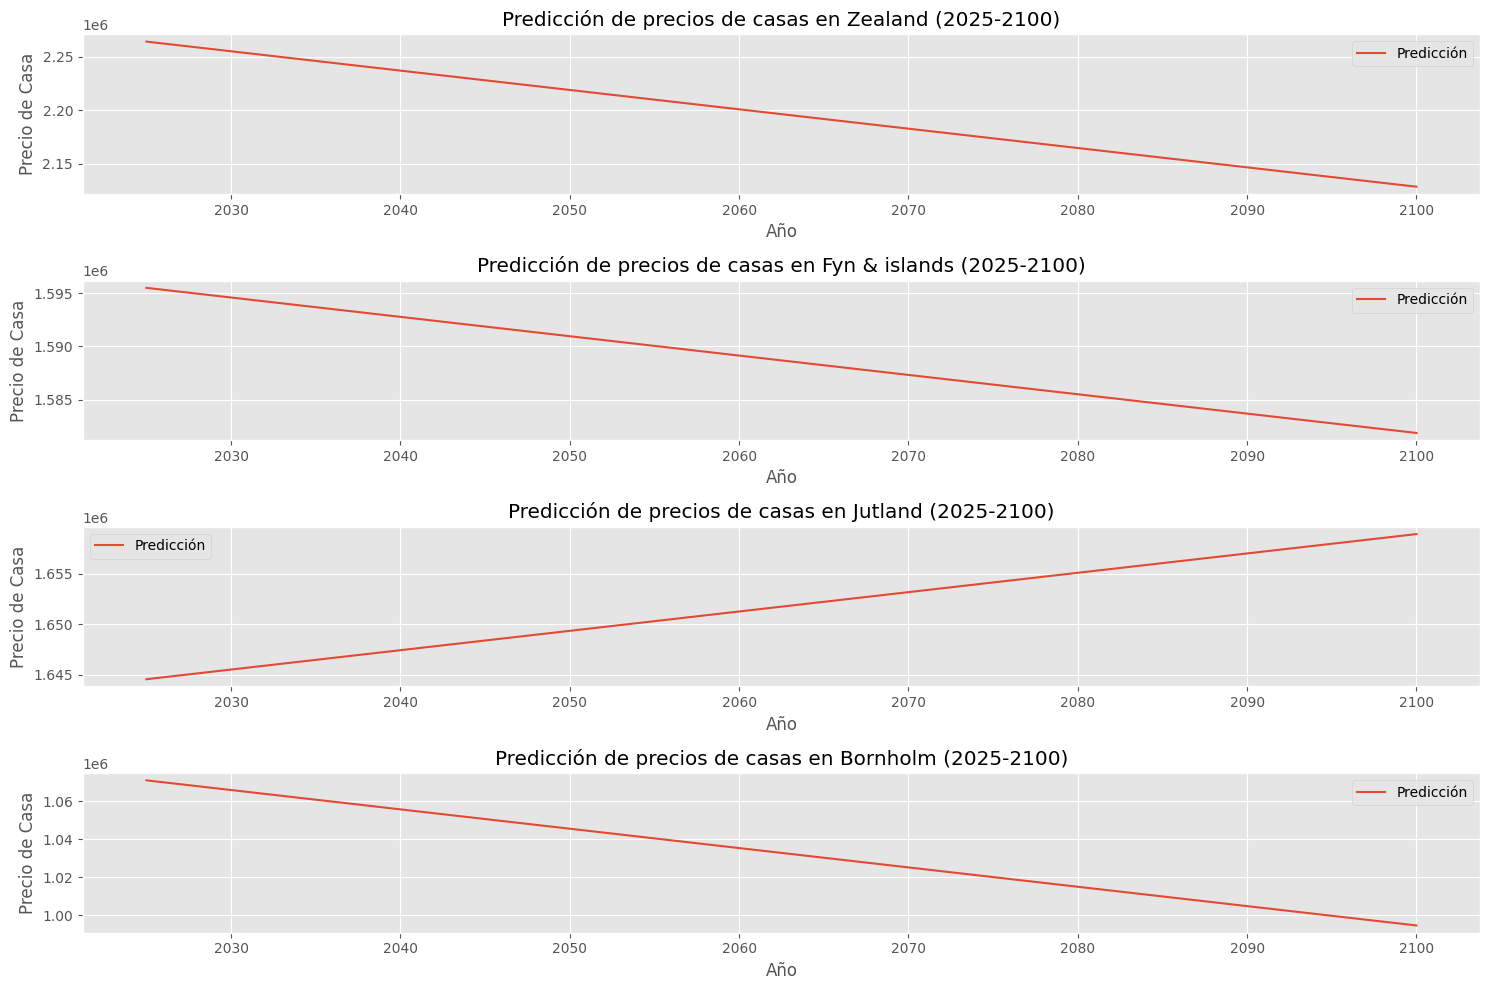

In [43]:
# Crear un modelo de regresión lineal para cada región
regiones = df_houses['region'].unique()
predicciones = {}

for region in regiones:
    region_data = df_houses[df_houses['region'] == region]
    X = region_data[['year_build']]
    y = region_data['purchase_price']
    
    model = LinearRegression()
    model.fit(X, y)
    
    # Predecir los precios de 2025 a 2100
    future_years = pd.DataFrame(np.arange(2025, 2101), columns=['year_build'])
    future_prices = model.predict(future_years)
    
    predicciones[region] = (future_years['year_build'].values, future_prices)

# Graficar las predicciones
plt.figure(figsize=(15, 10))

for i, region in enumerate(regiones):
    plt.subplot(len(regiones), 1, i + 1)
    years, prices = predicciones[region]
    plt.plot(years, prices, label='Predicción')
    plt.title(f'Predicción de precios de casas en {region} (2025-2100)')
    plt.xlabel('Año')
    plt.ylabel('Precio de Casa')
    plt.legend()

plt.tight_layout()
plt.show()

### Predicción de la evolución de precios con variables macroeconómicas de interés e inflación

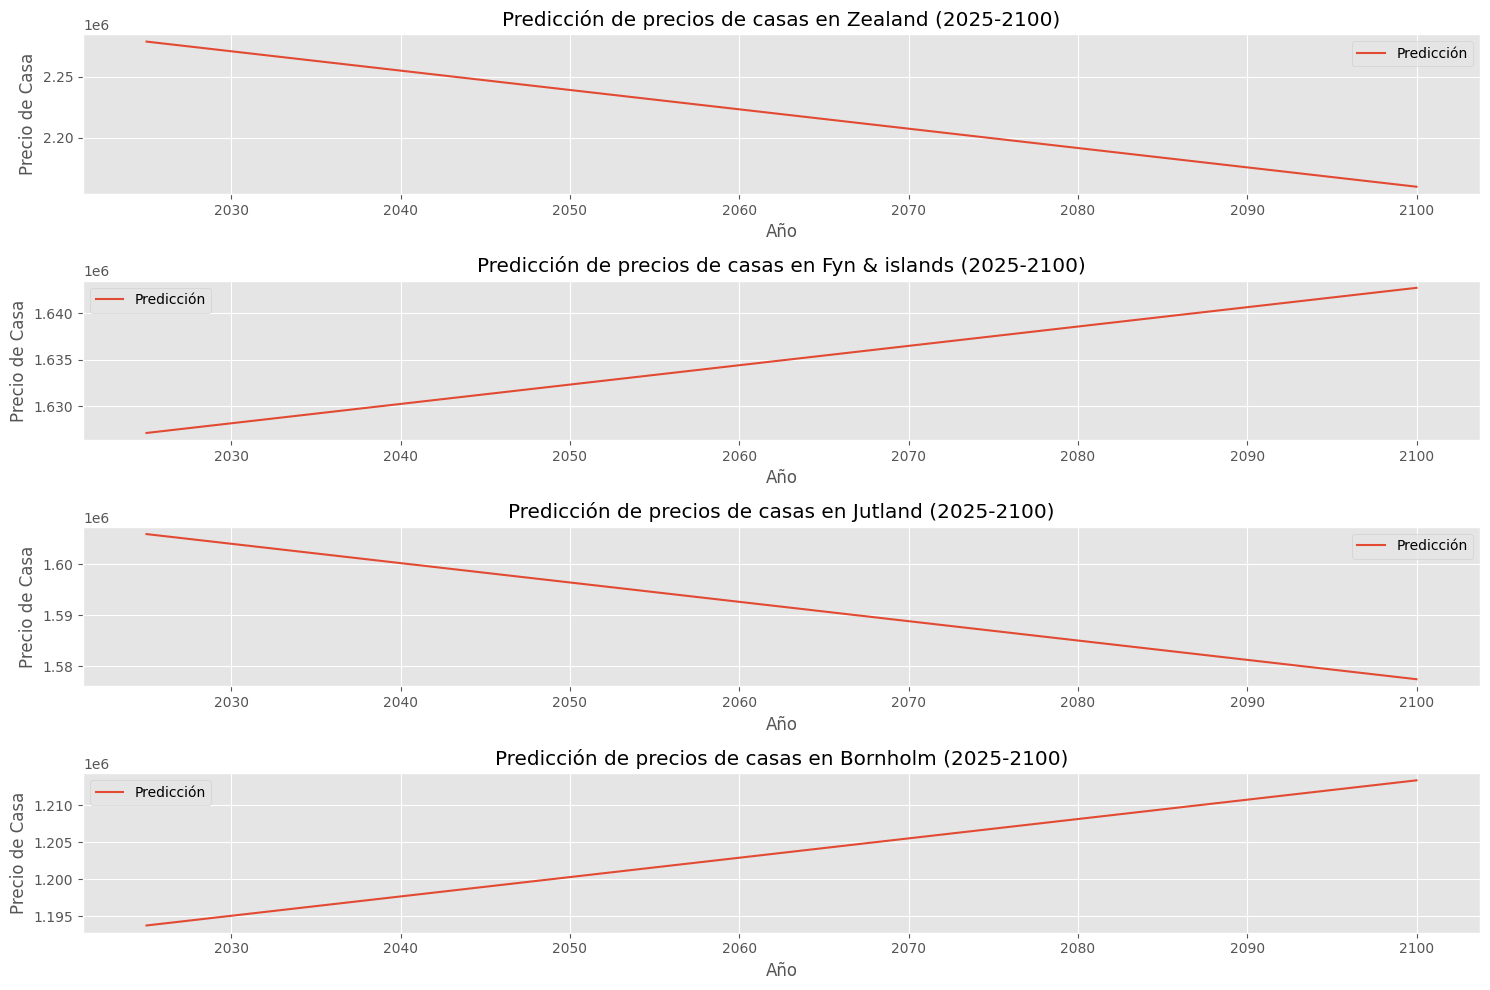

In [44]:
from sklearn.impute import SimpleImputer

regiones = df_houses['region'].unique()
predicciones = {}

for region in regiones:
    region_data = df_houses[df_houses['region'] == region]
    # Incluimos más variables predictoras
    X = region_data[['year_build', 'sqm', 'nom_interest_rate%', 'dk_ann_infl_rate%']]
    y = region_data['purchase_price']
    
    # Imputar valores faltantes
    imputer = SimpleImputer(strategy='mean')
    X = imputer.fit_transform(X)
    
    model = LinearRegression()
    model.fit(X, y)
    
    # Predecir los precios de 2025 a 2100
    future_years = np.arange(2025, 2101)
    future_data = pd.DataFrame({
        'year_build': future_years,
        'sqm': np.mean(region_data['sqm']),
        'nom_interest_rate%': np.mean(region_data['nom_interest_rate%']),
        'dk_ann_infl_rate%': np.mean(region_data['dk_ann_infl_rate%'])
    })
    
    future_prices = model.predict(imputer.transform(future_data))
    
    predicciones[region] = (future_years, future_prices)

# Graficar las predicciones
plt.figure(figsize=(15, 10))

for i, region in enumerate(regiones):
    plt.subplot(len(regiones), 1, i + 1)
    years, prices = predicciones[region]
    plt.plot(years, prices, label='Predicción')
    plt.title(f'Predicción de precios de casas en {region} (2025-2100)')
    plt.xlabel('Año')
    plt.ylabel('Precio de Casa')
    plt.legend()

plt.tight_layout()
plt.show()

### Tipos de casa por región en los próximos años

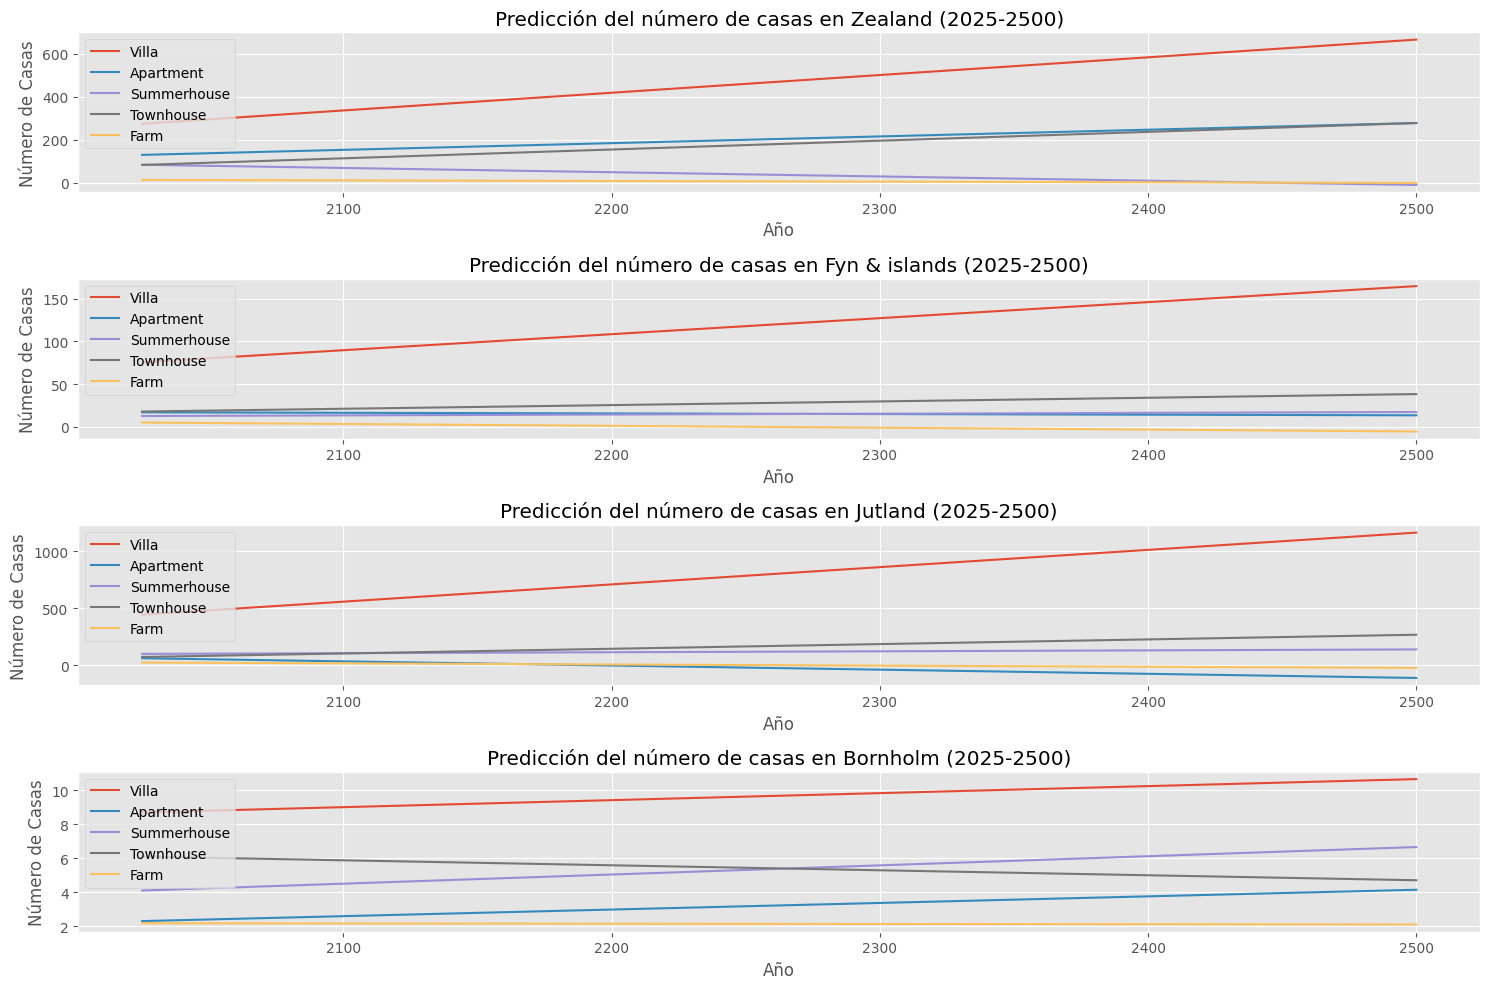

In [45]:
# Contar el número de casas por año, región y tipo de casa
df_houses['Numero_de_Casas'] = df_houses.groupby(['year_build', 'region', 'house_type'])['house_id'].transform('count')

# Crear un modelo de regresión lineal para cada tipo de casa en cada región
regiones = df_houses['region'].unique()
tipos_de_casa = df_houses['house_type'].unique()
predicciones = {}

for region in regiones:
    predicciones[region] = {}
    for tipo in tipos_de_casa:
        region_tipo_data = df_houses[(df_houses['region'] == region) & (df_houses['house_type'] == tipo)]
        X = region_tipo_data[['year_build']]
        y = region_tipo_data['Numero_de_Casas']
        
        model = LinearRegression()
        model.fit(X, y)
        
        # Predecir el número de casas de 2025 a 2500
        future_years = pd.DataFrame(np.arange(2025, 2501), columns=['year_build'])
        future_casas = model.predict(future_years)
        
        predicciones[region][tipo] = (future_years['year_build'].values, future_casas)

# Graficar las predicciones
plt.figure(figsize=(15, 10))

for i, region in enumerate(regiones):
    plt.subplot(len(regiones), 1, i + 1)
    for tipo in tipos_de_casa:
        years, casas = predicciones[region][tipo]
        plt.plot(years, casas, label=tipo)
    plt.title(f'Predicción del número de casas en {region} (2025-2500)')
    plt.xlabel('Año')
    plt.ylabel('Número de Casas')
    plt.legend()

plt.tight_layout()
plt.show()

### Predicción de los precios según tipo de casa por región

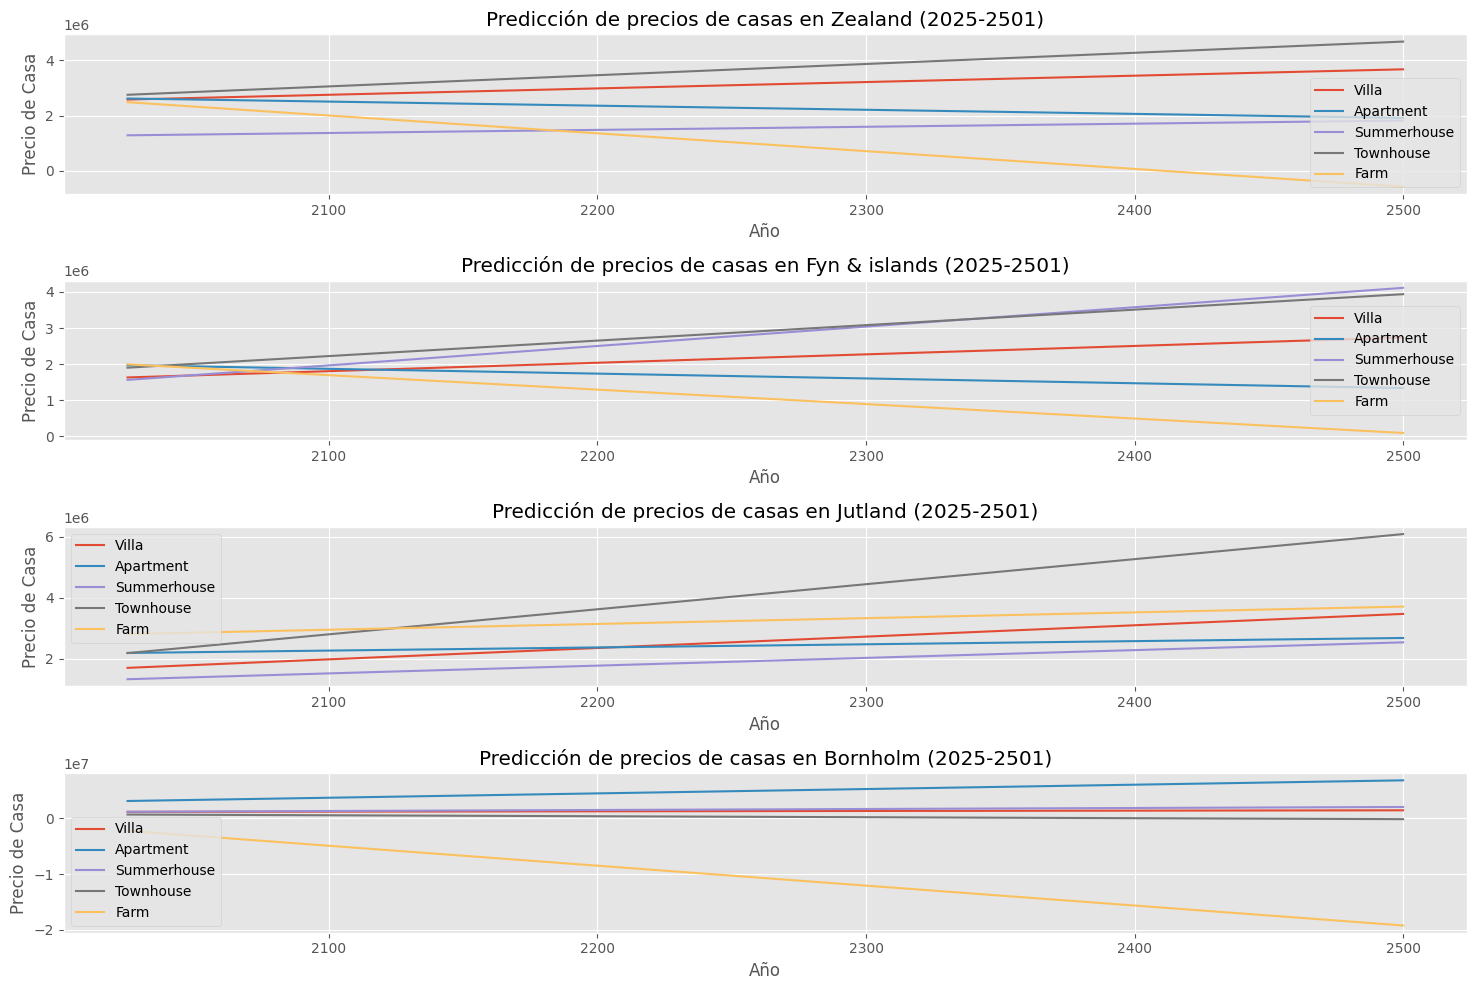

In [46]:
# Crear un modelo de regresión lineal para cada tipo de casa en cada región
regiones = df_houses['region'].unique()
tipos_de_casa = df_houses['house_type'].unique()
predicciones = {}

for region in regiones:
    predicciones[region] = {}
    for tipo in tipos_de_casa:
        region_tipo_data = df_houses[(df_houses['region'] == region) & (df_houses['house_type'] == tipo)]
        X = region_tipo_data[['year_build']]
        y = region_tipo_data['purchase_price']
        
        model = LinearRegression()
        model.fit(X, y)
        
        # Predecir los precios de 2025 a 2500
        future_years = pd.DataFrame(np.arange(2025, 2501), columns=['year_build'])
        future_precios = model.predict(future_years)
        
        predicciones[region][tipo] = (future_years['year_build'].values, future_precios)

# Graficar las predicciones
plt.figure(figsize=(15, 10))

for i, region in enumerate(regiones):
    plt.subplot(len(regiones), 1, i + 1)
    for tipo in tipos_de_casa:
        years, precios = predicciones[region][tipo]
        plt.plot(years, precios, label=tipo)
    plt.title(f'Predicción de precios de casas en {region} (2025-2501)')
    plt.xlabel('Año')
    plt.ylabel('Precio de Casa')
    plt.legend()

plt.tight_layout()
plt.show()

### Predicción de los metros cuadrados por región y según tipo de casa

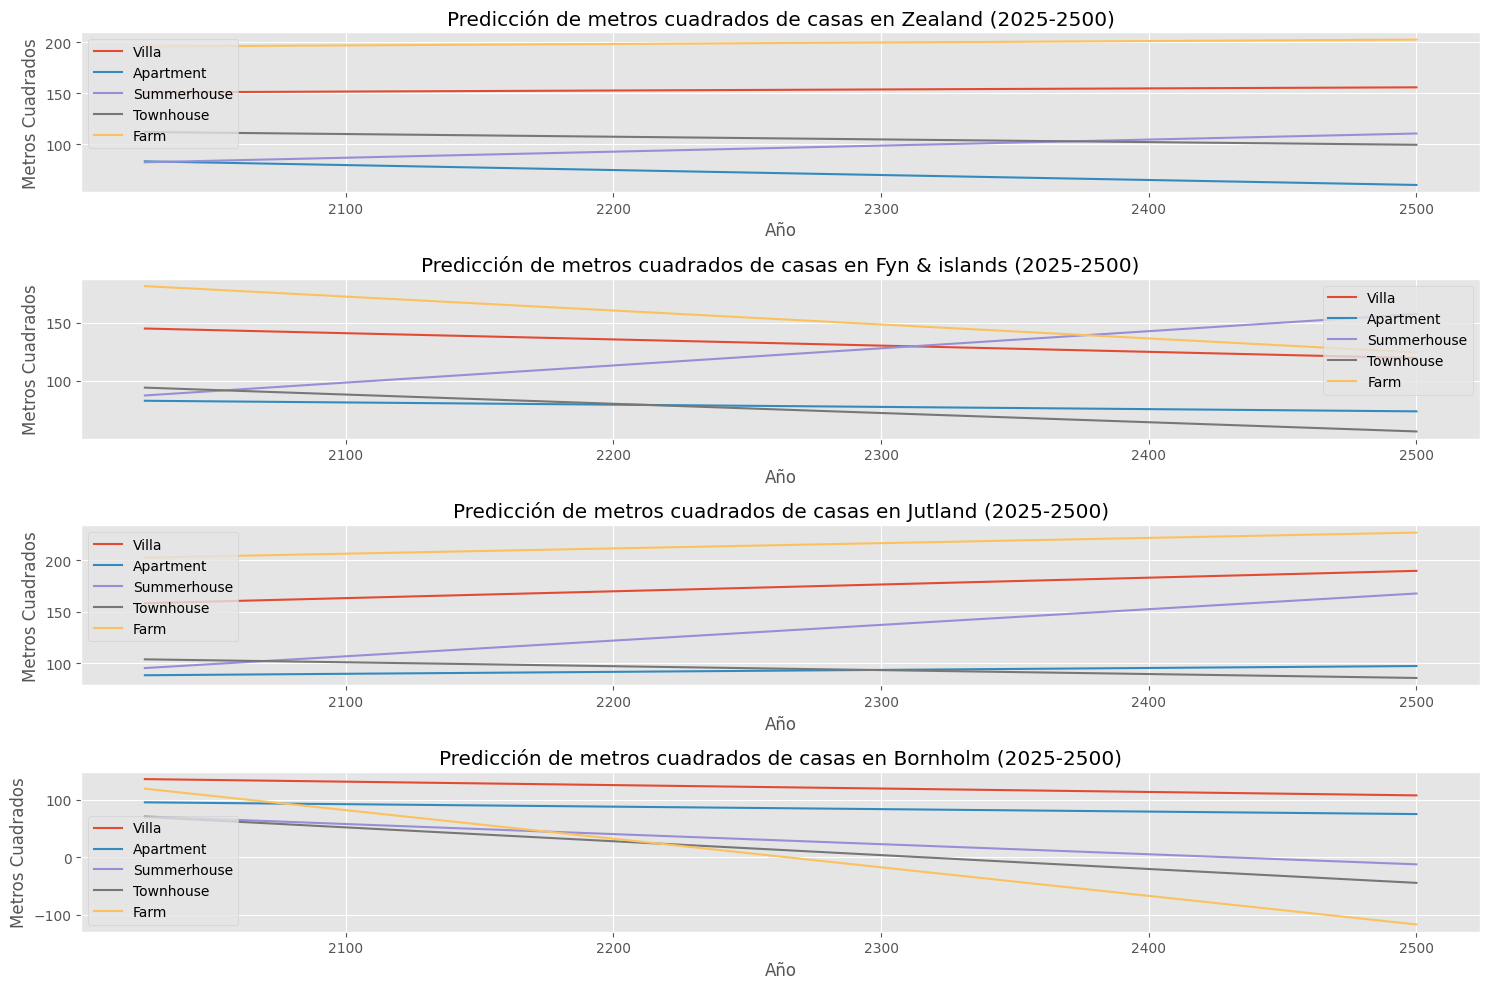

In [47]:
# Crear un modelo de regresión lineal para cada tipo de casa en cada región
regiones = df_houses['region'].unique()
tipos_de_casa = df_houses['house_type'].unique()
predicciones = {}

for region in regiones:
    predicciones[region] = {}
    for tipo in tipos_de_casa:
        region_tipo_data = df_houses[(df_houses['region'] == region) & (df_houses['house_type'] == tipo)]
        X = region_tipo_data[['year_build']]
        y = region_tipo_data['sqm']
        
        model = LinearRegression()
        model.fit(X, y)
        
        # Predecir los metros cuadrados de 2025 a 2500
        future_years = pd.DataFrame(np.arange(2025, 2501), columns=['year_build'])
        future_metros = model.predict(future_years)
        
        predicciones[region][tipo] = (future_years['year_build'].values, future_metros)

# Graficar las predicciones
plt.figure(figsize=(15, 10))

for i, region in enumerate(regiones):
    plt.subplot(len(regiones), 1, i + 1)
    for tipo in tipos_de_casa:
        years, metros = predicciones[region][tipo]
        plt.plot(years, metros, label=tipo)
    plt.title(f'Predicción de metros cuadrados de casas en {region} (2025-2500)')
    plt.xlabel('Año')
    plt.ylabel('Metros Cuadrados')
    plt.legend()

plt.tight_layout()
plt.show()

### Predicción del precio según metros cuadrados por región y según tipo de casa

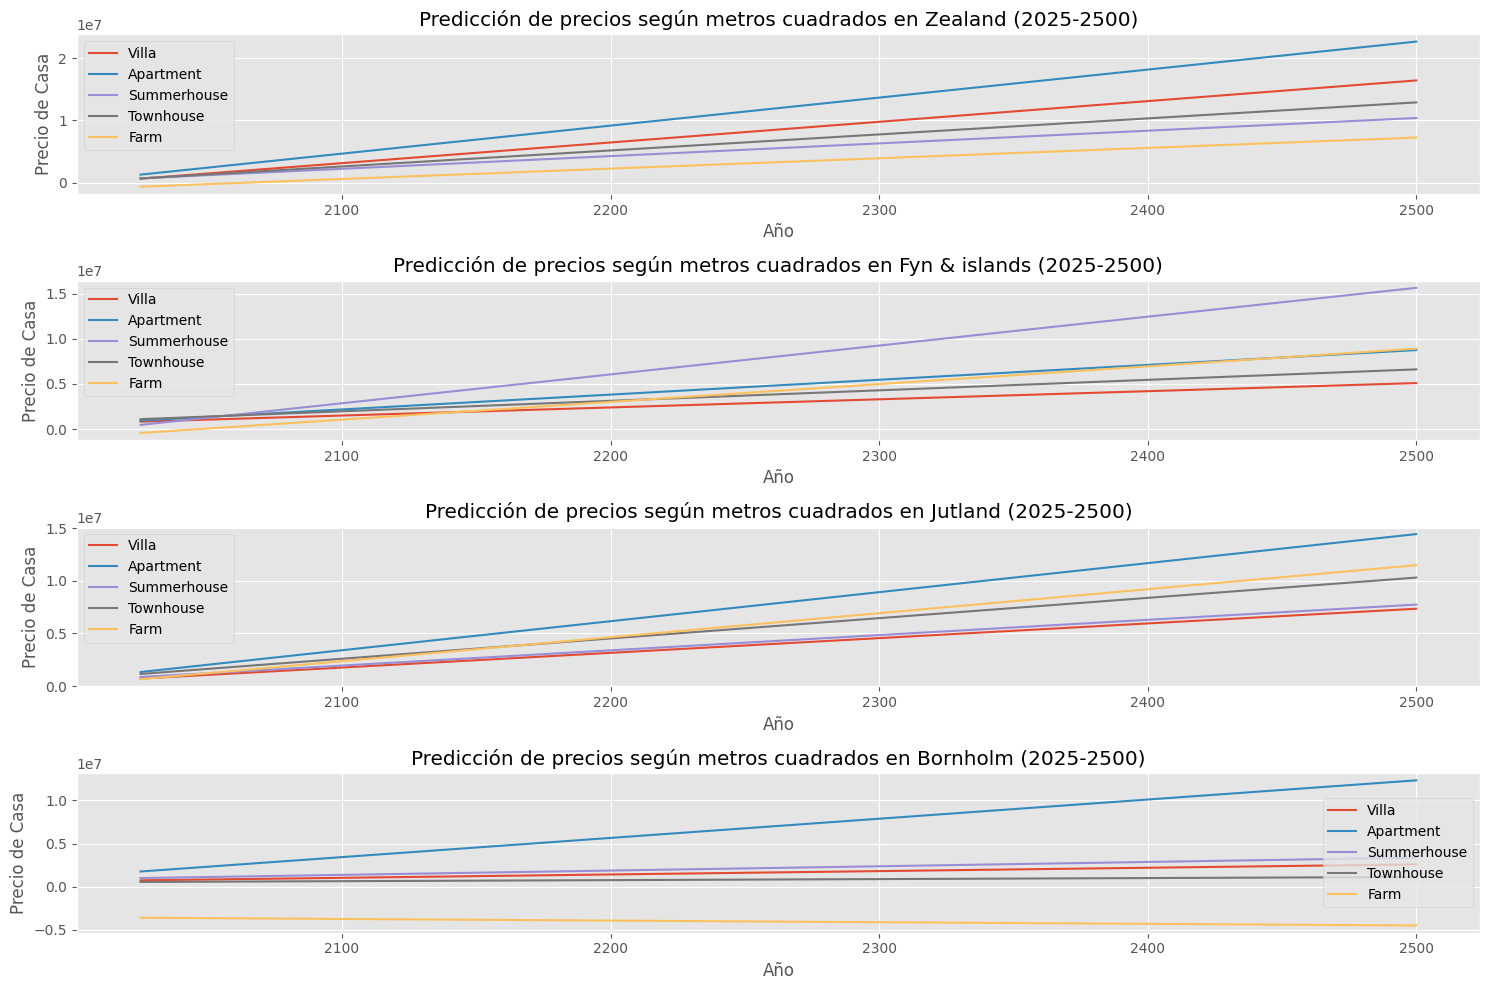

In [48]:
# Crear un modelo de regresión lineal para cada tipo de casa en cada región
regiones = df_houses['region'].unique()
tipos_de_casa = df_houses['house_type'].unique()
predicciones = {}

for region in regiones:
    predicciones[region] = {}
    for tipo in tipos_de_casa:
        region_tipo_data = df_houses[(df_houses['region'] == region) & (df_houses['house_type'] == tipo)]
        X = region_tipo_data[['year_build', 'sqm']]
        y = region_tipo_data['purchase_price']
        
        model = LinearRegression()
        model.fit(X, y)
        
        # Predecir los precios de 2025 a 2500
        future_years = np.arange(2025, 2501)
        future_metros = np.linspace(region_tipo_data['sqm'].min(), region_tipo_data['sqm'].max(), len(future_years))
        future_data = pd.DataFrame({'year_build': future_years, 'sqm': future_metros})
        future_precios = model.predict(future_data)
        
        predicciones[region][tipo] = (future_years, future_metros, future_precios)

# Graficar las predicciones
plt.figure(figsize=(15, 10))

for i, region in enumerate(regiones):
    plt.subplot(len(regiones), 1, i + 1)
    for tipo in tipos_de_casa:
        years, metros, precios = predicciones[region][tipo]
        plt.plot(years, precios, label=tipo)
    plt.title(f'Predicción de precios según metros cuadrados en {region} (2025-2500)')
    plt.xlabel('Año')
    plt.ylabel('Precio de Casa')
    plt.legend()

plt.tight_layout()
plt.show()

### Predicción de número de casas según número de habitaciones por regiones.

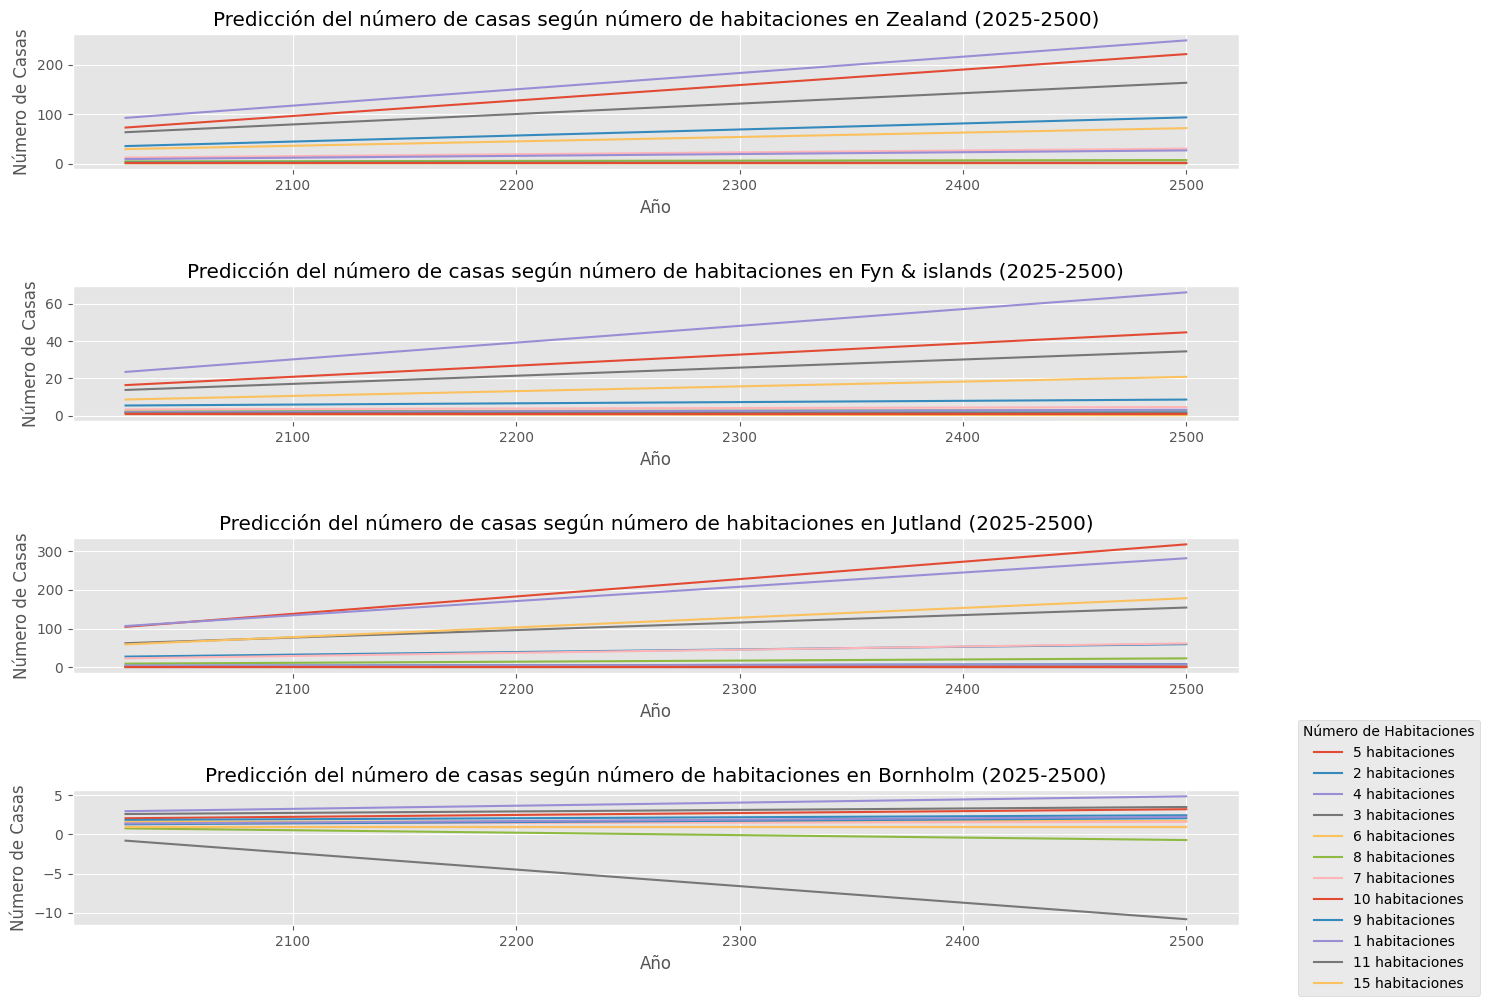

In [49]:
# Contar el número de casas para cada combinación de región y número de habitaciones
df_counts = df_houses.groupby(['year_build', 'region', 'no_rooms']).size().reset_index(name='num_houses')

# Crear un modelo de regresión lineal para cada combinación de región y número de habitaciones
regiones = df_houses['region'].unique()
num_habitaciones = df_houses['no_rooms'].unique()
predicciones = {}

for region in regiones:
    predicciones[region] = {}
    for num_hab in num_habitaciones:
        region_hab_data = df_counts[(df_counts['region'] == region) & (df_counts['no_rooms'] == num_hab)]
        if not region_hab_data.empty:
            X = region_hab_data[['year_build']]
            y = region_hab_data['num_houses']
            
            model = LinearRegression()
            model.fit(X, y)
            
            # Predecir el número de casas de 2025 a 2500
            future_years = pd.DataFrame(np.arange(2025, 2501), columns=['year_build'])
            future_houses = model.predict(future_years)
            
            predicciones[region][num_hab] = (future_years['year_build'].values, future_houses)

# Graficar las predicciones
plt.figure(figsize=(15, 10))

for i, region in enumerate(regiones):
    plt.subplot(len(regiones), 1, i + 1)
    for num_hab in num_habitaciones:
        if num_hab in predicciones[region]:
            years, houses = predicciones[region][num_hab]
            plt.plot(years, houses, label=f'{num_hab} habitaciones')
    plt.title(f'Predicción del número de casas según número de habitaciones en {region} (2025-2500)')
    plt.xlabel('Año')
    plt.ylabel('Número de Casas')

# Ajustar la leyenda para que esté en una sola columna
plt.legend(title='Número de Habitaciones', bbox_to_anchor=(1.05, 0.5), loc='center left', borderaxespad=0., ncol=1)

plt.tight_layout()
plt.show()

### Clasificación de viviendas con RandomForest

Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.73      0.82      0.77     13295
           1       0.31      0.21      0.25      1882
           2       0.37      0.28      0.32      4823

    accuracy                           0.63     20000
   macro avg       0.47      0.44      0.45     20000
weighted avg       0.60      0.63      0.61     20000

Matriz de confusión:
[[10872   518  1905]
 [ 1018   404   460]
 [ 3084   377  1362]]


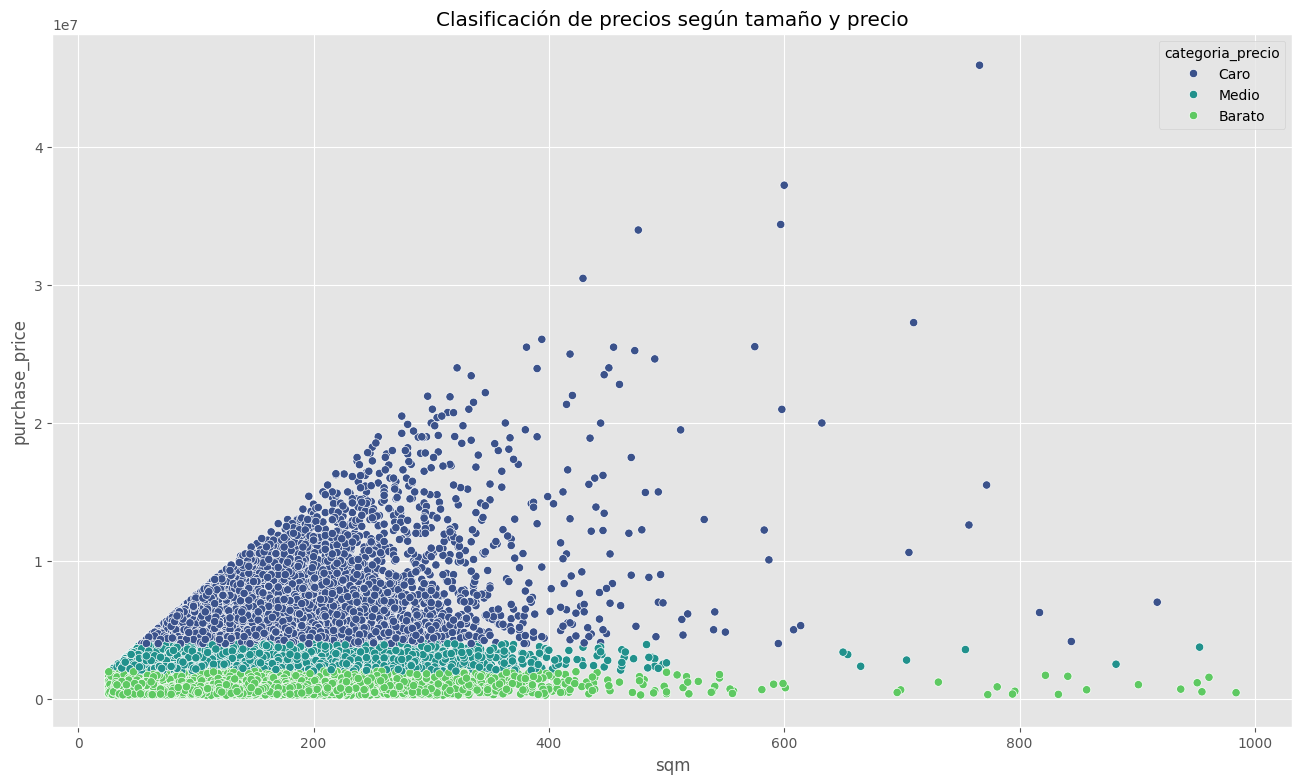

In [54]:
# Crear categorías de precio
def categorizar_precio(precio):
    if precio < 2000000:  # Barato
        return 'Barato'
    elif 2000000 <= precio < 4000000:  # Medio
        return 'Medio'
    else:  # Caro
        return 'Caro'

df_houses['categoria_precio'] = df_houses['purchase_price'].apply(categorizar_precio)

# Convertir categorías en valores numéricos
label_encoder = LabelEncoder()
df_houses['categoria_precio_encoded'] = label_encoder.fit_transform(df_houses['categoria_precio'])

# Asegurarse de que 'year_build' es un entero
df_houses['year_build'] = pd.to_numeric(df_houses['year_build'], errors='coerce')
df_houses = df_houses.dropna(subset=['year_build'])
df_houses['year_build'] = df_houses['year_build'].astype(int)

# Seleccionar características para el modelo
X = df_houses[['no_rooms', 'sqm', 'year_build', 'house_type']]
y = df_houses['categoria_precio_encoded']

# Convertir variables categóricas en dummies
X = pd.get_dummies(X, drop_first=True)

# Dividir datos
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Entrenar el modelo RandomForest
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Evaluar el modelo
y_pred = rf.predict(X_test)
print("Reporte de clasificación:")
print(classification_report(y_test, y_pred))
print("Matriz de confusión:")
print(confusion_matrix(y_test, y_pred))

# Gráfico con la clasificación
plt.figure(figsize=(16, 9))
sns.scatterplot(x='sqm', y='purchase_price', data=df_houses, hue='categoria_precio', palette='viridis')
plt.title('Clasificación de precios según tamaño y precio')
plt.show()


### Predicción de probabilidad de venta

[[ 1316   361]
 [  251 18072]]
              precision    recall  f1-score   support

           0       0.84      0.78      0.81      1677
           1       0.98      0.99      0.98     18323

    accuracy                           0.97     20000
   macro avg       0.91      0.89      0.90     20000
weighted avg       0.97      0.97      0.97     20000



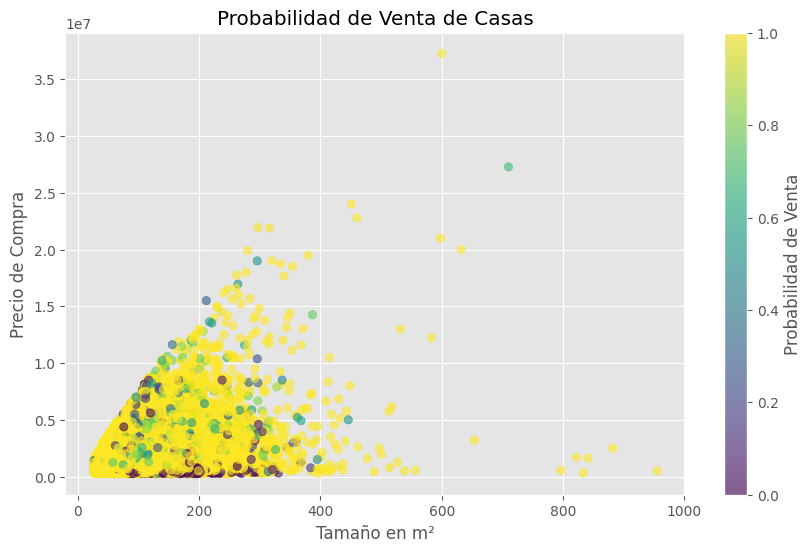

In [41]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt

# Crear la columna 'year' extrayendo el año de la columna 'date'
df_houses['year'] = pd.to_datetime(df_houses['date']).dt.year

# Crear la columna 'sold' como objetivo (1: vendida, 0: no vendida)
df_houses['sold'] = df_houses.apply(lambda x: 1 if x['year'] > x['year_build'] else 0, axis=1)

# Seleccionar características y variable objetivo
features = ['year_build', 'no_rooms', 'sqm', 'purchase_price']
target = 'sold'

# Preparar los datos
X = df_houses[features]
y = df_houses[target]

# Dividir en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Crear y entrenar el modelo
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Hacer predicciones
y_pred = model.predict(X_test)

# Evaluar el modelo
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

# Obtener probabilidades predichas
y_probs = model.predict_proba(X_test)[:, 1]

# Crear un DataFrame con los resultados
results = X_test.copy()
results['sold'] = y_test
results['prob_sold'] = y_probs

# Gráfico de las probabilidades de venta
plt.figure(figsize=(10, 6))
plt.scatter(results['sqm'], results['purchase_price'], c=results['prob_sold'], cmap='viridis', alpha=0.6)
plt.colorbar(label='Probabilidad de Venta')
plt.xlabel('Tamaño en m²')
plt.ylabel('Precio de Compra')
plt.title('Probabilidad de Venta de Casas')
plt.show()

### Predicción de ventas por región

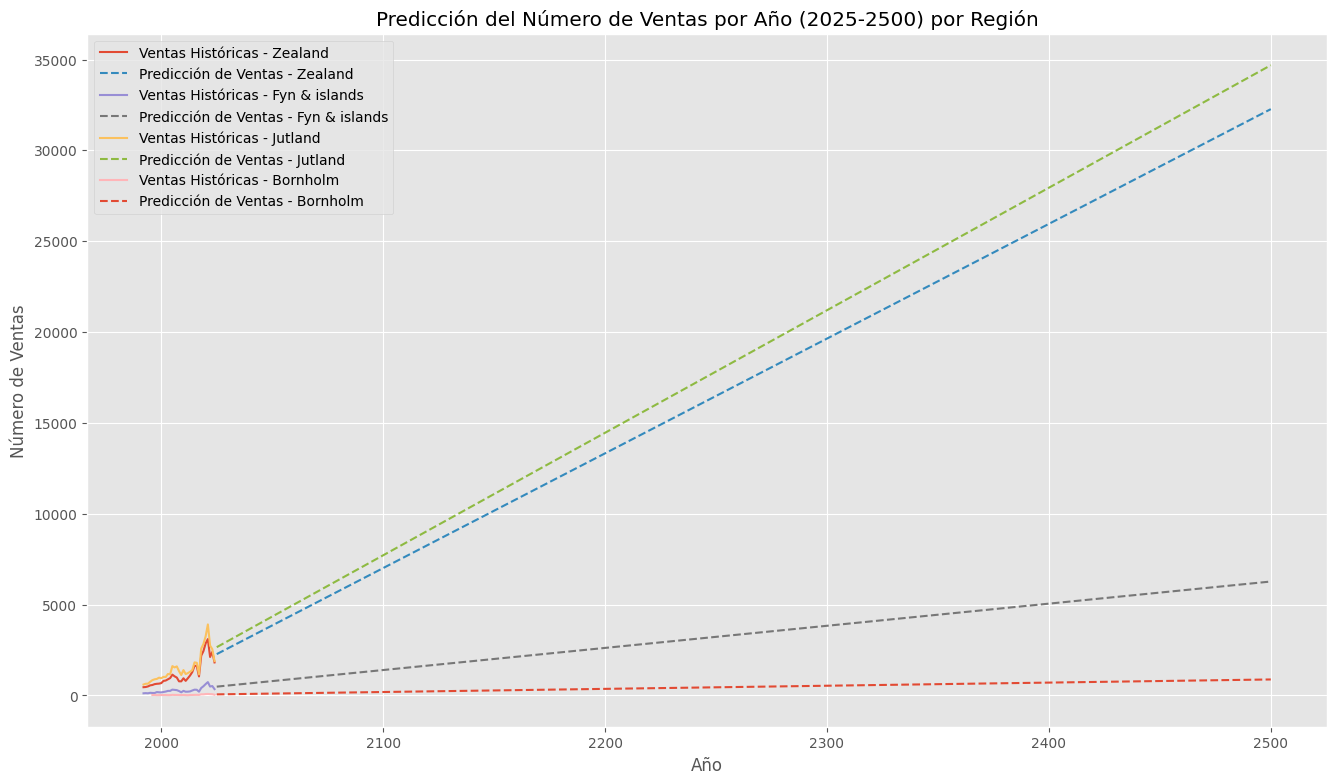

In [ ]:
from sklearn.linear_model import LinearRegression

# Crear un diccionario para almacenar las predicciones por región
predicciones_por_region = {}

# Obtener las regiones únicas
regiones = df_houses['region'].unique()

# Iterar sobre cada región
for region in regiones:
    # Filtrar los datos por región
    region_data = df_houses[df_houses['region'] == region].copy()
    
    # Extraer el año de la columna 'date'
    region_data.loc[:, 'year'] = pd.to_datetime(region_data['date']).dt.year
    
    # Contar el número de ventas por año
    ventas_por_año = region_data['year'].value_counts().sort_index()
    
    # Preparar los datos
    X = ventas_por_año.index.values.reshape(-1, 1)
    y = ventas_por_año.values
    
    # Crear y entrenar el modelo
    model = LinearRegression()
    model.fit(X, y)
    
    # Predecir el número de ventas de 2025 a 2500
    future_years = np.arange(2025, 2501).reshape(-1, 1)
    future_sales = model.predict(future_years)
    
    # Almacenar las predicciones en el diccionario
    predicciones_por_region[region] = (ventas_por_año.index, ventas_por_año.values, future_years, future_sales)

# Graficar las predicciones por región
plt.figure(figsize=(16, 9))

for region, (historical_years, historical_sales, future_years, future_sales) in predicciones_por_region.items():
    plt.plot(historical_years, historical_sales, label=f'Ventas Históricas - {region}')
    plt.plot(future_years, future_sales, linestyle='--', label=f'Predicción de Ventas - {region}')

plt.title('Predicción del Número de Ventas por Año (2025-2500) por Región')
plt.xlabel('Año')
plt.ylabel('Número de Ventas')
plt.legend()
plt.show()

### Predicción de ventas por tipo de casa y región

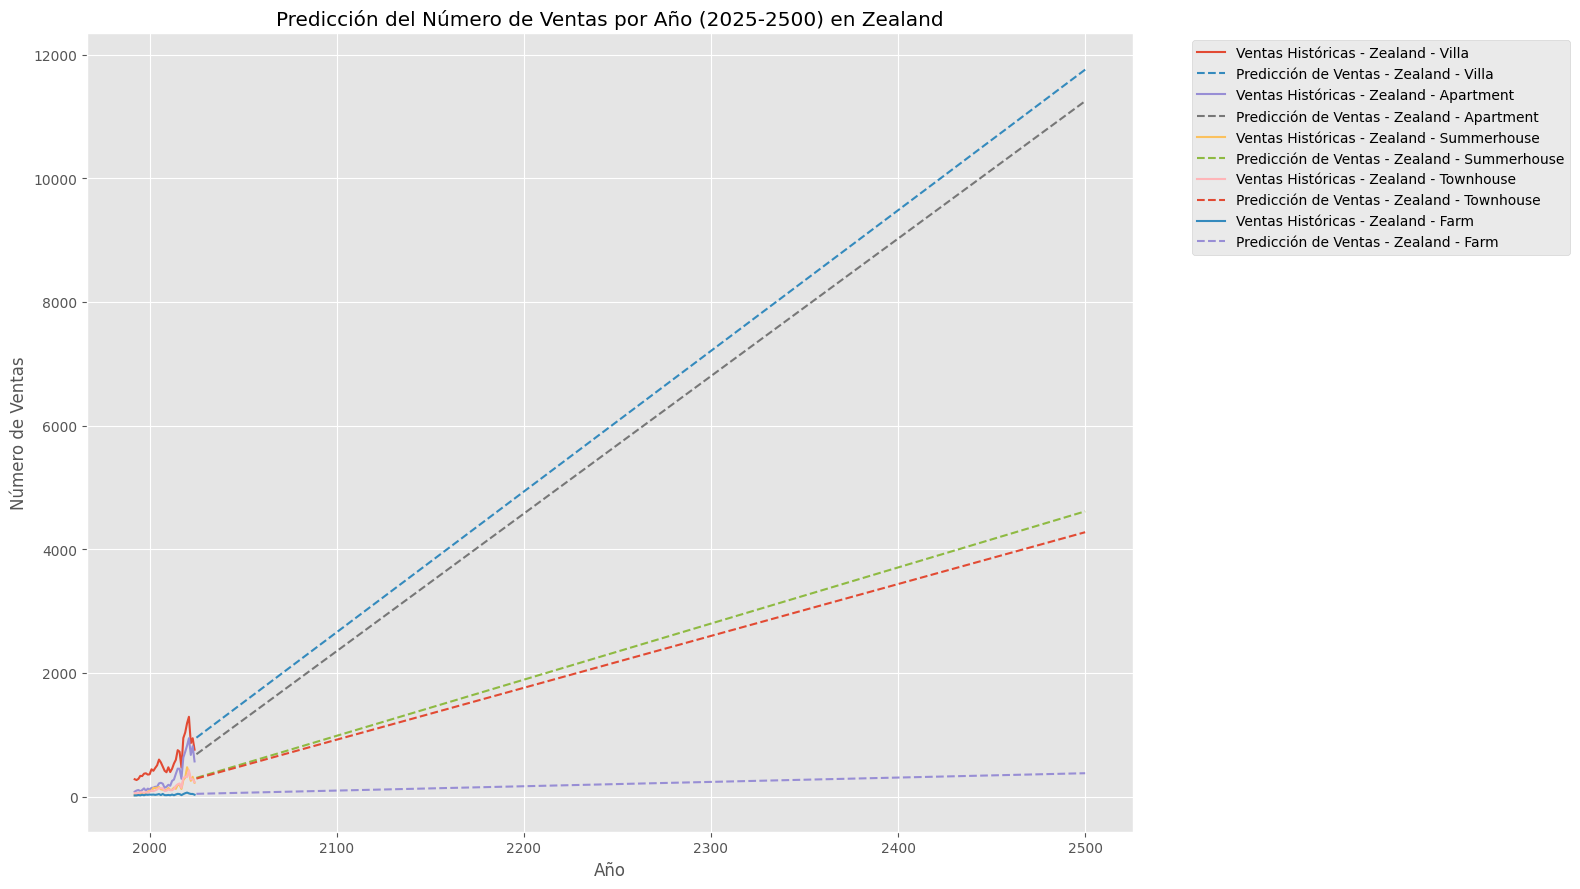

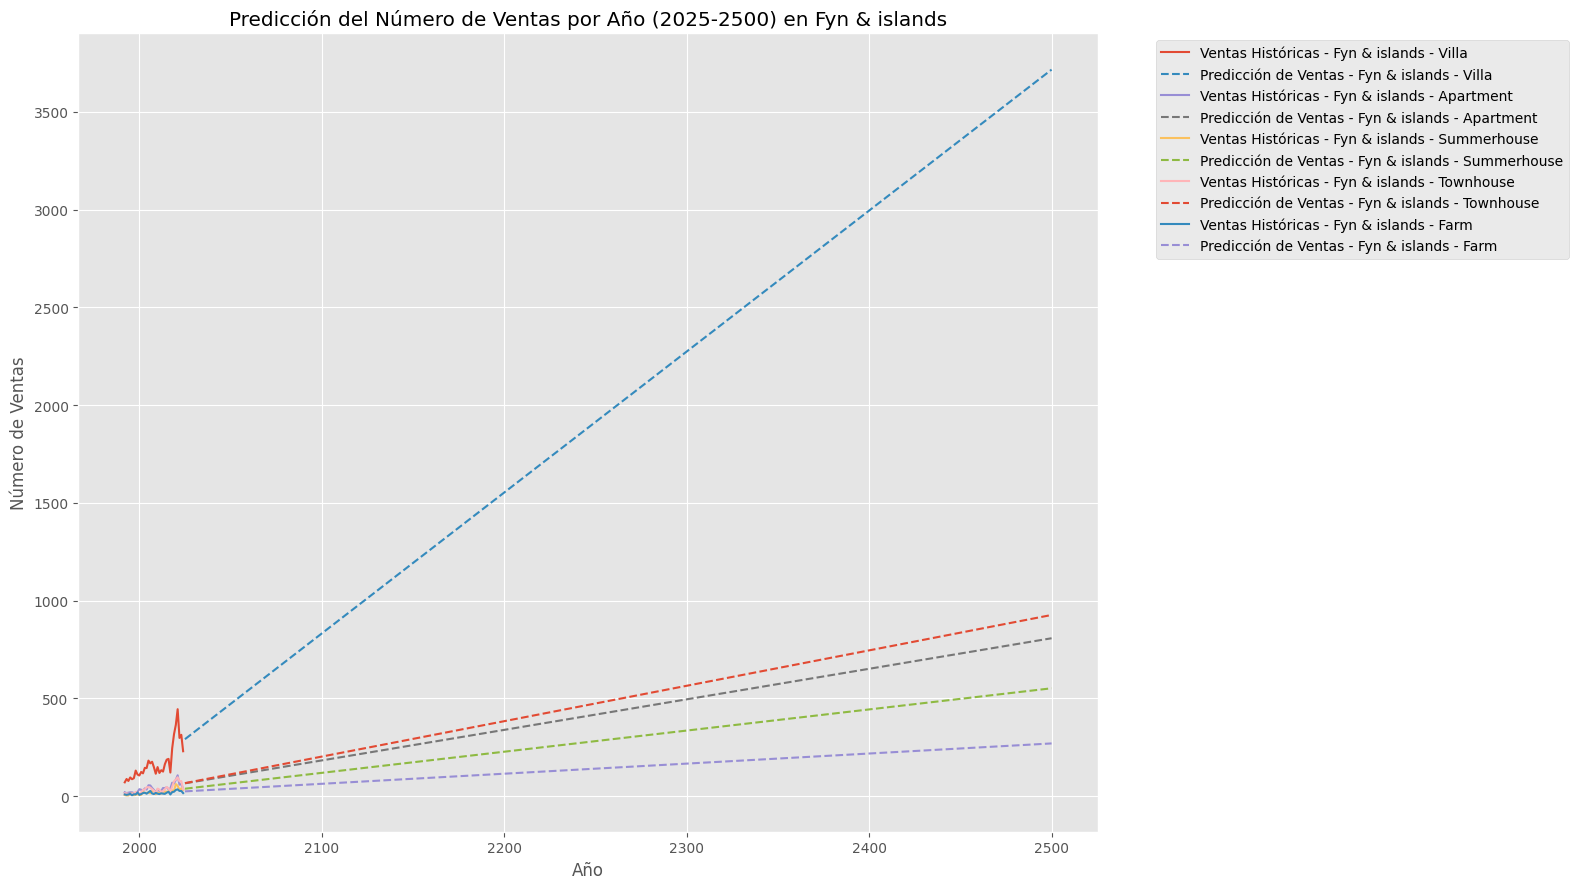

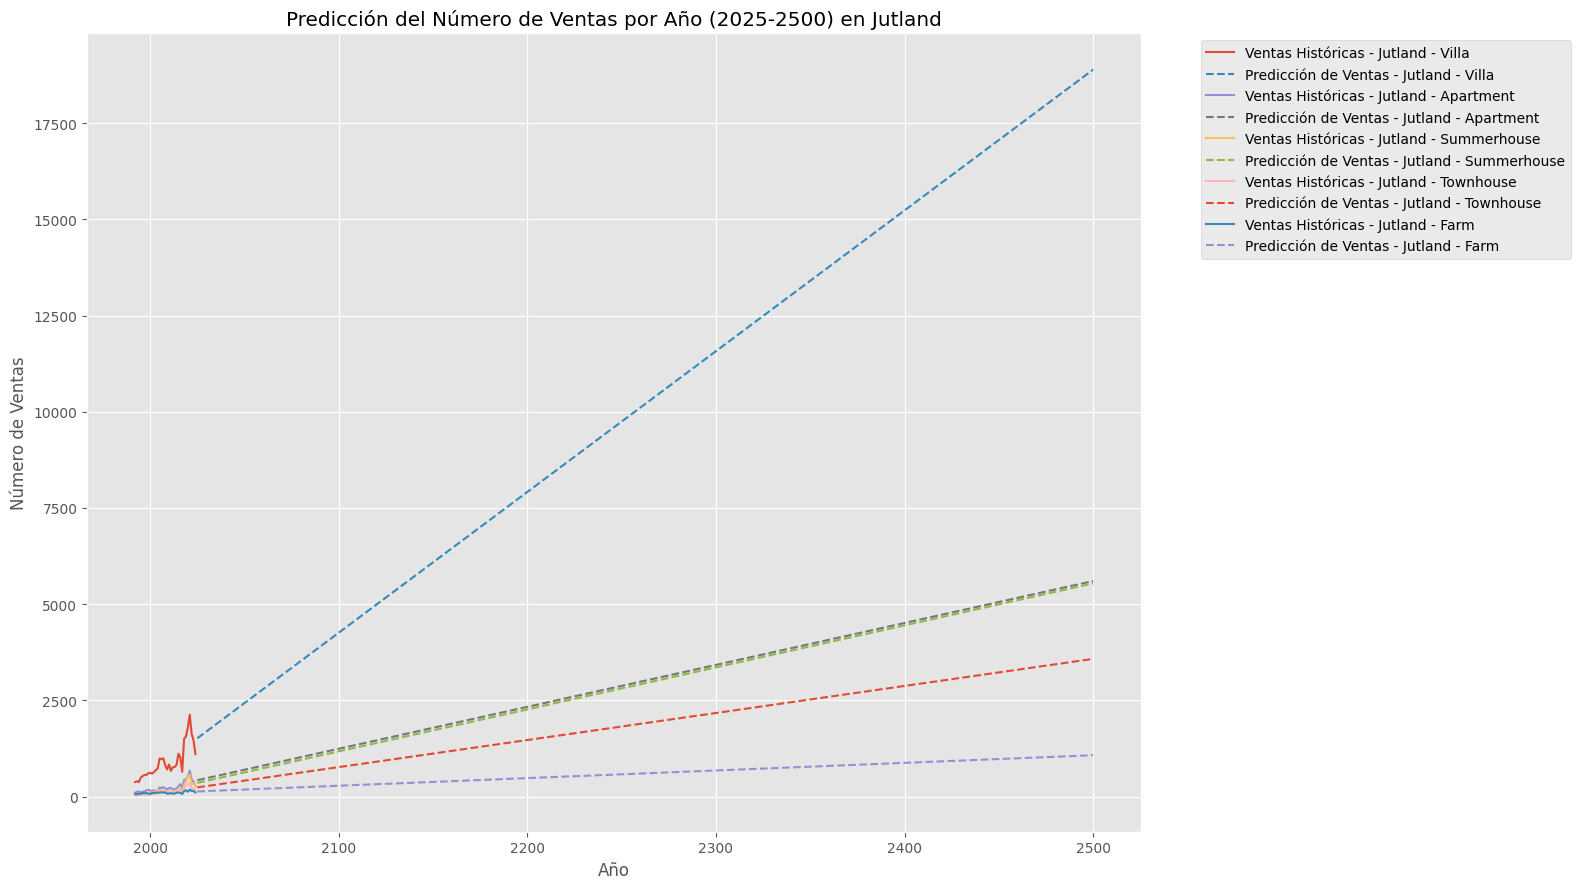

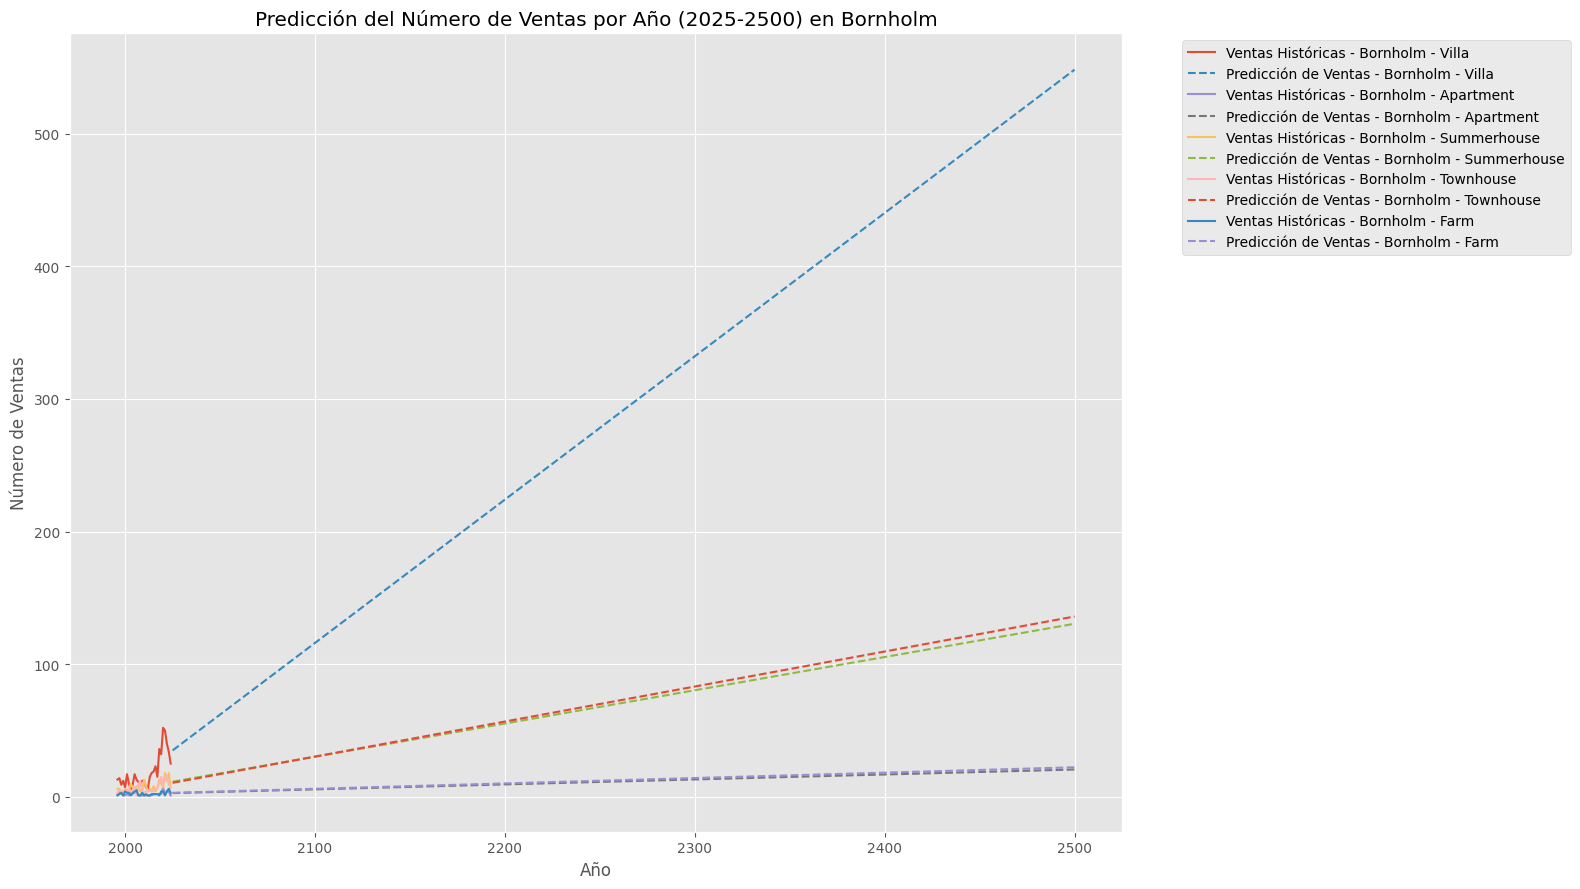

In [53]:
# Crear un diccionario para almacenar las predicciones por región y tipo de casa
predicciones_por_region_tipo = {}

# Obtener las regiones y tipos de casa únicos
regiones = df_houses['region'].unique()
tipos_de_casa = df_houses['house_type'].unique()

# Iterar sobre cada región y tipo de casa
for region in regiones:
    predicciones_por_region_tipo[region] = {}
    for tipo in tipos_de_casa:
        # Filtrar los datos por región y tipo de casa
        region_tipo_data = df_houses[(df_houses['region'] == region) & (df_houses['house_type'] == tipo)].copy()
        
        # Extraer el año de la columna 'date'
        region_tipo_data.loc[:, 'year'] = pd.to_datetime(region_tipo_data['date']).dt.year
        
        # Contar el número de ventas por año
        ventas_por_año = region_tipo_data['year'].value_counts().sort_index()
        
        if not ventas_por_año.empty:
            # Preparar los datos
            X = ventas_por_año.index.values.reshape(-1, 1)
            y = ventas_por_año.values
            
            # Crear y entrenar el modelo
            model = LinearRegression()
            model.fit(X, y)
            
            # Predecir el número de ventas de 2025 a 2500
            future_years = np.arange(2025, 2501).reshape(-1, 1)
            future_sales = model.predict(future_years)
            
            # Almacenar las predicciones en el diccionario
            predicciones_por_region_tipo[region][tipo] = (ventas_por_año.index, ventas_por_año.values, future_years, future_sales)

# Graficar las predicciones por región y tipo de casa
for region, tipos in predicciones_por_region_tipo.items():
    plt.figure(figsize=(16, 9))
    for tipo, (historical_years, historical_sales, future_years, future_sales) in tipos.items():
        plt.plot(historical_years, historical_sales, label=f'Ventas Históricas - {region} - {tipo}')
        plt.plot(future_years, future_sales, linestyle='--', label=f'Predicción de Ventas - {region} - {tipo}')
    plt.title(f'Predicción del Número de Ventas por Año (2025-2500) en {region}')
    plt.xlabel('Año')
    plt.ylabel('Número de Ventas')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()
